In [1]:
Options = [("Gauss","Weighted_ELBO"),("Beta","ELBO"),("Beta","KLUB"),("Beta","KLUB_conditional"),("Beta","KLUB_marginal"),("Gauss","KLUB")]
Data_Choices = ["Toy1","Toy2"]

'''
To reproduce the results in the paper, run the demo code with "diffusion_option,loss_option = Options[i]", where i=0,1,2,3,4, and with "data_choice = Data_Choices[j]", where j=0,1
'''

diffusion_option,loss_option = Options[2]
data_choice = Data_Choices[0]

In [2]:
import torch
import numpy as np
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import sys
from torch.distributions import Gamma
from torch.distributions import Beta

MIN = torch.finfo(torch.float32).tiny
EPS = torch.finfo(torch.float32).eps



In [3]:


SaveCheckPoint  = True



#predict x0 or noise in Gaussian diffusion
Predict_x0 = False
    
#Concentration parameter in beta diffusion 
eta = torch.tensor(10000,dtype=torch.float32)

Beta_Linear_Schedule = True

if Beta_Linear_Schedule ==False:
    #Define sigmoid scheduling start, end, and power: alpha_t= torch.sigmoid(sigmoid_start+(sigmoid_end-sigmoid_start)*t**sigmoid_power)
    sigmoid_start = 9
    sigmoid_end = -9
    sigmoid_power = 0.5
else:
    #Define beta linear schedule 
    beta_max = 20
    beta_min= 0.1
    beta_d = beta_max-beta_min


#Position embedding dimension
embed_size = 20

#NFEs, the number of steps in reverse diffusion
T = 200

#BatchSize
BatchSize=1000

#for beta diffusion, the output of the generator NN is sent to sigmoid, and then scaled by Scale and shifted by Shift, so the output is always between [Shift, Shift+Scale]
#Scale=0.39
#Shift=0.60
#Scale=0.8
#Shift=0.1
Scale=1
Shift=0
#The data values are assumed to lie within the range (0,1); If not, please adjust Scale and Shift accordingly.

In [4]:
#Define functions
def log_gamma(alpha):
    return torch.log(torch._standard_gamma(alpha.to(torch.float32)))
def KL_gamma(*args):
    """
    Calculates the KL divergence between two Gamma distributions.
    args[0]: alpha_p, the shape of the first Gamma distribution Gamma(alpha_p,beta_p).
    args[1]: alpha_q,the shape of the second Gamma distribution Gamma(alpha_q,beta_q).
    args[2]: beta_p, the rate (inverse scale) of the first Gamma distribution Gamma(alpha_p,beta_p).
    args[3]: beta_q, the rate (inverse scale) of the second Gamma distribution Gamma(alpha_q,beta_q).
    """    
    alpha_p = args[0]
    alpha_q = args[1]
    KL = (alpha_p-alpha_q)*torch.digamma(alpha_p)-torch.lgamma(alpha_p)+torch.lgamma(alpha_q)
    if len(args)>2:
        beta_p = args[2]
        beta_q = args[3]
        KL = KL + alpha_q*(torch.log(beta_p)-torch.log(beta_q))+alpha_p*(beta_q/beta_p-1.0)  
    return KL

def KL_beta(alpha_p,beta_p,alpha_q,beta_q):
    """
    Calculates the KL divergence between two Beta distributions
    KL(Beta(alpha_p,beta_p) || Beta(alpha_q,beta_q))
    """
    KL =KL_gamma(alpha_p,alpha_q)+KL_gamma(beta_p,beta_q)-KL_gamma(alpha_p+beta_p,alpha_q+beta_q)
    return KL

def get_positional_embedding(embed_size, positions,alpha=None):
    """
    positions is a tensor whose values are between 0 and 1
    if embed_size=0, then return alpha as positional embedding
    """
    #positions = torch.linspace(0, 1, seq_length)
    #positions = positions.unsqueeze(1)
    
    #positions = -positions.logit()/8/1000
    
    seq_length = len(positions)
    angles = 1000*positions / torch.pow(10000, torch.arange(0, embed_size, 2).float() / embed_size)
    embeddings = torch.zeros(seq_length, embed_size)
    if embed_size>0:
        embeddings[:, 0::2] = torch.sin(angles)
        embeddings[:, 1::2] = torch.cos(angles)
    if alpha==None:
        #embeddings[:,-1] = positions.squeeze(1)
        return embeddings
    else:
        return torch.cat([embeddings,alpha],dim=1)
    

    
def gauss_reverse_sampler(model,datashape,num_steps,alpha,embed_size,alpha_min=None):
    
    if 1:
        step_indices = torch.arange(num_steps)
        t_steps = 1-step_indices / (num_steps - 1)*(1-1e-5)
        t_steps = torch.cat([t_steps, torch.zeros_like(t_steps[:1])])
    else:
        t_steps = 1- (torch.arange(0,num_steps+1)+1e-3)/(num_steps+2*1e-3)

    
    if Beta_Linear_Schedule==False:
        logit_alpha = sigmoid_start + (sigmoid_end-sigmoid_start) * (t_steps**sigmoid_power)
    else:
        logit_alpha = (-0.5*beta_d*t_steps**2-beta_min*t_steps).to(torch.float64).exp().logit()
    
    alpha = logit_alpha.sigmoid()
    
    
    if alpha_min is None:
        alpha_min = alpha[0]
        
    x = torch.randn(datashape)
           
    #embedding_pos = alpha.unsqueeze(1)
    embedding_pos = t_steps.unsqueeze(1)
    
    pe = get_positional_embedding(embed_size, embedding_pos)
    
    for i, (logit_alpha_cur,logit_alpha_next) in enumerate(zip(logit_alpha[:-1], logit_alpha[1:])): # 0, ..., N-1
        
        alpha_cur = logit_alpha_cur.sigmoid()
        alpha_next = logit_alpha_next.sigmoid()
        
        embedding = pe[i].repeat(x.shape[0], 1)
        with torch.no_grad(): 
            if Predict_x0:
                x0_hat = model(x, embedding)
            else:
                noise_pred = model(x,embedding) 
                x0_hat = ((x - torch.sqrt(1-alpha_cur)*noise_pred)/torch.sqrt(alpha_cur))
                
            x = torch.sqrt(alpha_next)/(1-alpha_cur)*(1-alpha_cur/alpha_next)*x0_hat\
                    +(1-alpha_next)/(1-alpha_cur)*torch.sqrt(alpha_cur/alpha_next)*x\
                    +torch.sqrt((1-alpha_next)/(1-alpha_cur)*(1-alpha_cur/alpha_next))*torch.randn_like(x)
    z_0 = x
    return x0_hat, z_0    

    
def beta_reverse_sampler(model,datashape,num_steps,alpha,diffusion_option,Scale,Shift,embed_size,alpha_min=None,x_0_prior=None):
    
    if 1:
        step_indices = torch.arange(num_steps)
        t_steps = 1-step_indices / (num_steps - 1)*(1-1e-5)
        t_steps = torch.cat([t_steps, torch.zeros_like(t_steps[:1])])
    else:
        t_steps = 1- (torch.arange(0,num_steps+1)+1e-3)/(num_steps+2*1e-3)
        
    
    if Beta_Linear_Schedule==False:
        logit_alpha = sigmoid_start + (sigmoid_end-sigmoid_start) * (t_steps**sigmoid_power)
    else:
        #logit_alpha = -0.5*beta_d*t_steps**2-beta_min*t_steps
        logit_alpha =(-0.5*beta_d*t_steps**2-beta_min*t_steps).to(torch.float64).exp().logit()
    
    alpha = logit_alpha.sigmoid()
    if alpha_min is None:
        alpha_min = alpha[0]
    if x_0_prior is None:
        latents = torch.ones(datashape)/2*Scale+Shift
        #latents = Beta(torch.ones(datashape),1.0).sample()*Scale+Shift
    else:
        latents = x_0_prior
    
    log_u = log_gamma( (eta * alpha_min * latents).to(torch.float32) )
    log_v = log_gamma( (eta - eta * alpha_min * latents).to(torch.float32) )
    x_next = (log_u - log_v)
    
    #embedding_pos = alpha.unsqueeze(1)
    embedding_pos = t_steps.unsqueeze(1)
    
    
    pe = get_positional_embedding(embed_size, embedding_pos)
    for i, (logit_alpha_cur,logit_alpha_next) in enumerate(zip(logit_alpha[:-1], logit_alpha[1:])): # 0, ..., N-1
        x_cur = x_next
        alpha_cur = logit_alpha_cur.sigmoid()
        alpha_next = logit_alpha_next.sigmoid()
        
        embedding = pe[i].repeat(x_next.shape[0], 1)
        with torch.no_grad(): 
            logit_x0_hat = model(x_cur, embedding)

        x0_hat = torch.sigmoid(logit_x0_hat) * Scale + Shift

        alpha_reverse = (eta*alpha_next-eta*alpha_cur)*x0_hat
        beta_reverse = eta-eta*alpha_next*x0_hat
        
        log_u = log_gamma(alpha_reverse.to(torch.float32))
        log_v = log_gamma(beta_reverse.to(torch.float32))

        concatenated = torch.cat((x_cur.unsqueeze(-1), (log_u-log_v).unsqueeze(-1), (x_cur+log_u-log_v).unsqueeze(-1)), dim=1)
        x_next = torch.logsumexp(concatenated, dim=1)
        
   
    out = (x0_hat- Shift) / Scale
    out1 = ((torch.sigmoid(x_next)/alpha_next- Shift) / Scale) #.clamp(0,1)
    return out, out1

    
def draw_minibatch(BatchSize=1000,data_choice="Toy1"):
    D = torch.tensor((1.0/7,2.0/7,3.0/7,4.0/7,5.0/7))
    if data_choice == "Toy1":
        """
        Toy data 1
        """    
        Type = torch.randint(0,5,(BatchSize,1))
        x0 = D[Type]
    elif data_choice == "Toy2":
        """
        Toy data 2
        """    
        Type = torch.randint(0,5,(BatchSize,1))
        x0 = torch.zeros(Type.shape)
        x0[Type==0] = (Beta(torch.ones((Type==0).sum()),1).sample()*0.1+0.1)
        x0[Type==1] = (Beta(torch.ones((Type==1).sum()),5).sample()*0.1+0.3)
        x0[Type==2] = 0.5
        x0[Type==3] = (Beta(torch.ones((Type==3).sum())*.5,.5).sample()*0.1+0.6)
        x0[Type==4] = 0.8
    else:
        print("invalid Toy data choice")
    return x0, D


In [5]:
from torch import nn
# Get cpu or gpu device for training.
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

class MLP(nn.Module):
    def __init__(self, input_size=1+embed_size, hidden_size=256, output_size=1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.activation1 = nn.ReLU()
        self.activation2 = nn.ReLU()

    def forward(self, logit_x_t, pe):
        # Input1 is a regular tensor of dimension 1
        # Input2 is a positional embedding tensor of dimension 20     
        x = self.fc1(torch.cat([logit_x_t,pe],dim=1))
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.fc3(x)
        return x
    
    # def weight_initial(self,m):
    #     if isinstance(m, nn.Linear):
    #         nn.init.xavier_uniform_(m.weight)
    #         nn.init.zeros_(m.bias)
        
model = MLP().to(device)
print(model)

lr  = torch.tensor(5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr)
if False:
    #optional lr scheduler; disabled by default
    from torch.optim.lr_scheduler import StepLR
    scheduler = StepLR(optimizer, step_size=1, gamma=0.95)

Using cpu device
MLP(
  (fc1): Linear(in_features=21, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (activation1): ReLU()
  (activation2): ReLU()
)


tensor([0.0000, 0.0101, 0.0202, 0.0303, 0.0404, 0.0505, 0.0606, 0.0707, 0.0808,
        0.0909, 0.1010, 0.1111, 0.1212, 0.1313, 0.1414, 0.1515, 0.1616, 0.1717,
        0.1818, 0.1919, 0.2020, 0.2121, 0.2222, 0.2323, 0.2424, 0.2525, 0.2626,
        0.2727, 0.2828, 0.2929, 0.3030, 0.3131, 0.3232, 0.3333, 0.3434, 0.3535,
        0.3636, 0.3737, 0.3838, 0.3939, 0.4040, 0.4141, 0.4242, 0.4343, 0.4444,
        0.4545, 0.4646, 0.4747, 0.4848, 0.4949, 0.5051, 0.5152, 0.5253, 0.5354,
        0.5455, 0.5556, 0.5657, 0.5758, 0.5859, 0.5960, 0.6061, 0.6162, 0.6263,
        0.6364, 0.6465, 0.6566, 0.6667, 0.6768, 0.6869, 0.6970, 0.7071, 0.7172,
        0.7273, 0.7374, 0.7475, 0.7576, 0.7677, 0.7778, 0.7879, 0.7980, 0.8081,
        0.8182, 0.8283, 0.8384, 0.8485, 0.8586, 0.8687, 0.8788, 0.8889, 0.8990,
        0.9091, 0.9192, 0.9293, 0.9394, 0.9495, 0.9596, 0.9697, 0.9798, 0.9899,
        1.0000])
tensor([1.0000e+00, 9.9798e-01, 9.9394e-01, 9.8791e-01, 9.7992e-01, 9.7003e-01,
        9.5829e-01, 9.4

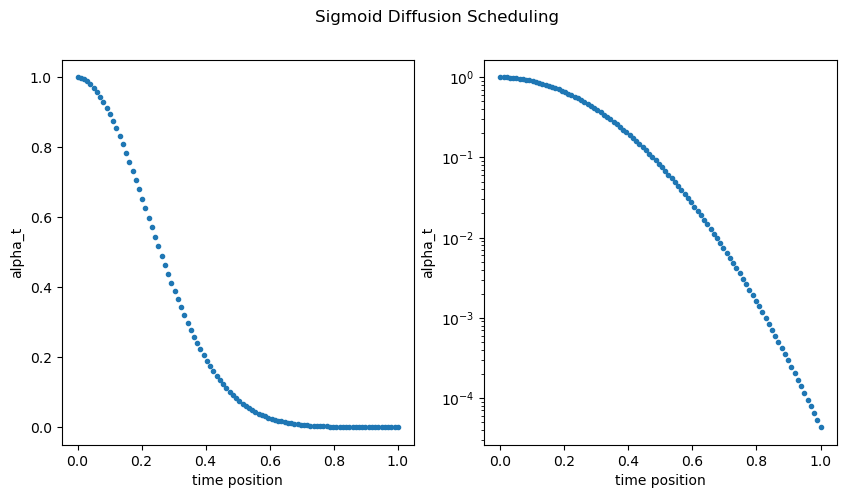

In [6]:
#Beta linear noise scheduling
fig, axs = plt.subplots(1, 2, figsize=(10, 5)) #, sharey=True)
position = torch.linspace(0, 1, 100)
print(position)
#axs[0].plot(position,torch.sigmoid(sigmoid_start+(sigmoid_end-sigmoid_start)*position**sigmoid_power))
axs[0].plot(position,torch.exp(-0.5*beta_d*position**2-beta_min*position),'.')
print(torch.exp(-0.5*beta_d*position**2-beta_min*position))
axs[0].set_xlabel("time position")
axs[0].set_ylabel("alpha_t")
#axs[1].semilogy(position,torch.sigmoid(sigmoid_start+(sigmoid_end-sigmoid_start)*position**sigmoid_power))
axs[1].semilogy(position,torch.exp(-0.5*beta_d*position**2-beta_min*position),'.')
axs[1].set_xlabel("time position")
axs[1].set_ylabel("alpha_t")
plt.suptitle('Sigmoid Diffusion Scheduling')
plt.show()

1000 tensor(0.3987, grad_fn=<MeanBackward0>)
1000 Wasserstein1 [0.07584224]
1000 JSD [0.57403056]
1000 Hellinger [0.87150437]


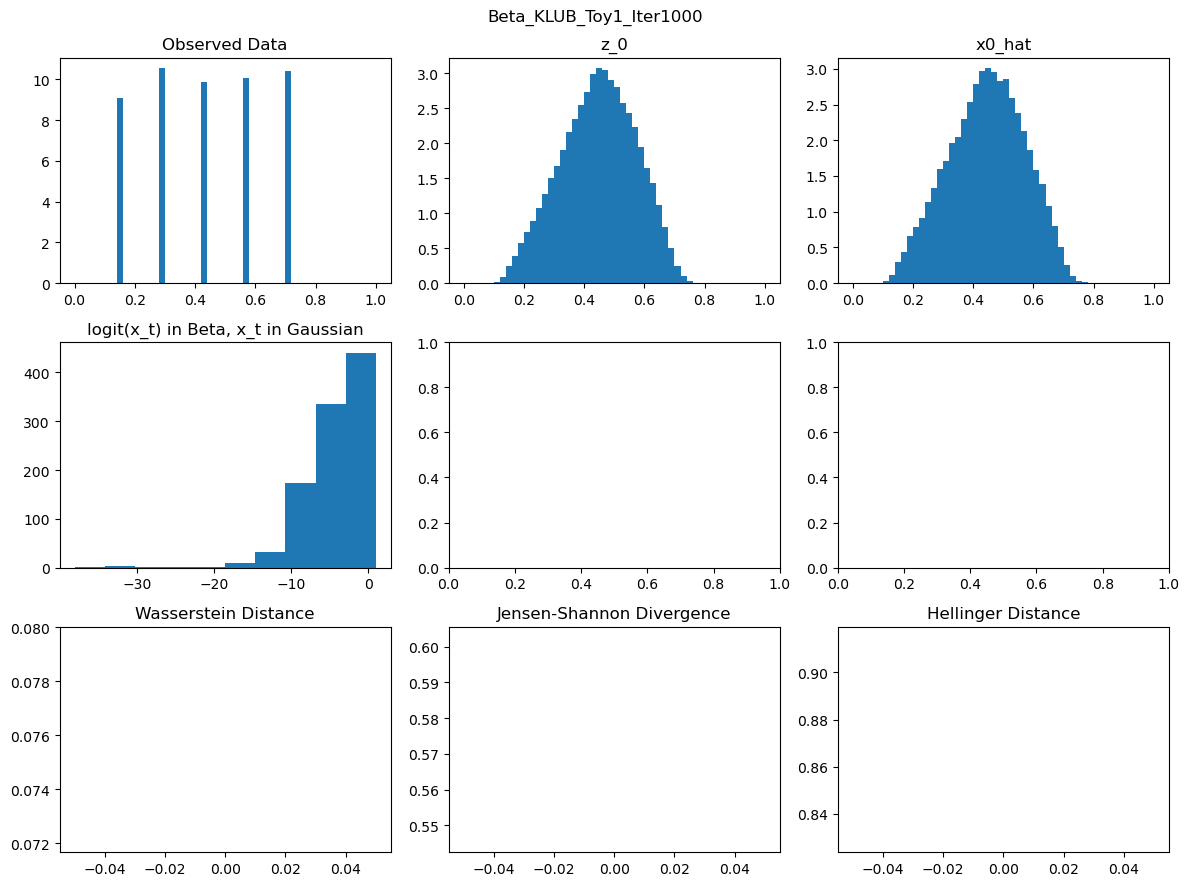

2000 tensor(0.2842, grad_fn=<MeanBackward0>)
2000 Wasserstein1 [0.07584224 0.0766233 ]
2000 JSD [0.57403056 0.55709281]
2000 Hellinger [0.87150437 0.85306834]


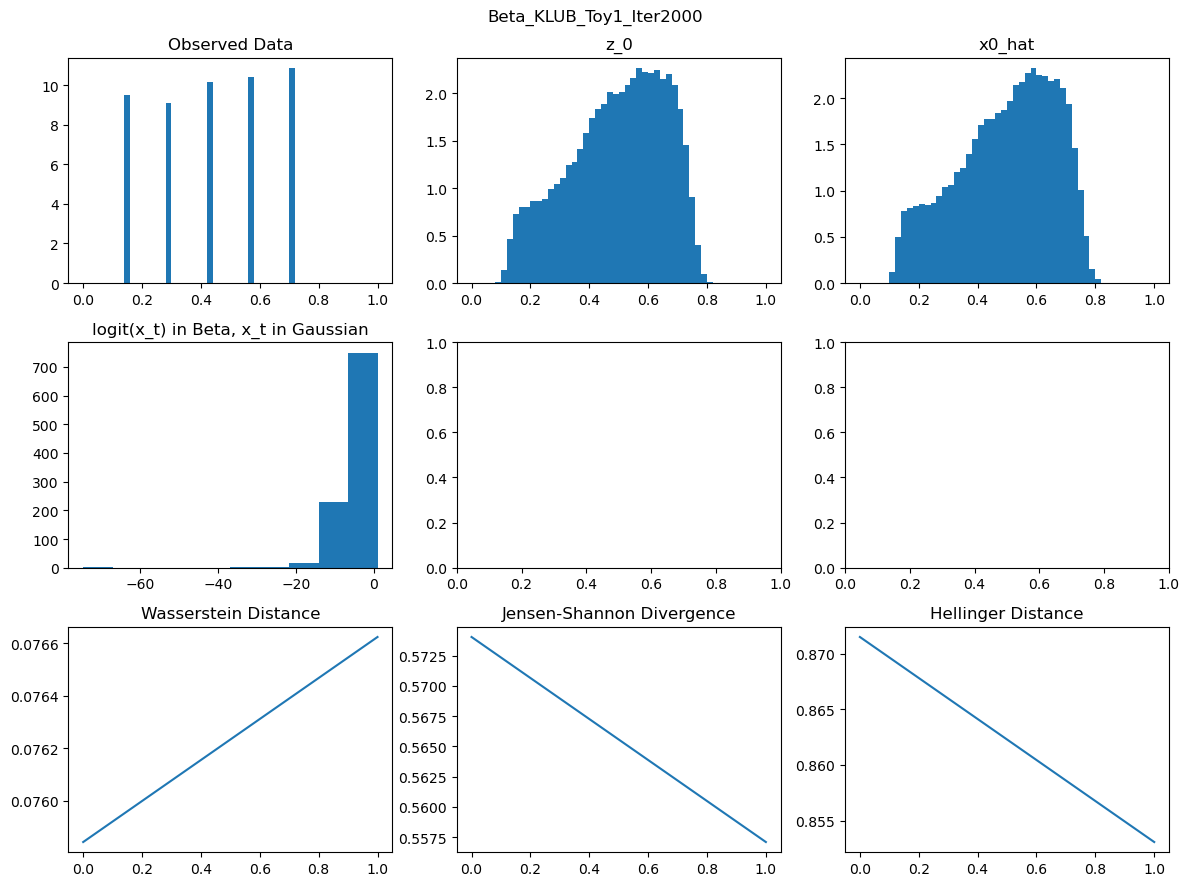

3000 tensor(0.2789, grad_fn=<MeanBackward0>)
3000 Wasserstein1 [0.07584224 0.0766233  0.04082273]
3000 JSD [0.57403056 0.55709281 0.54251595]
3000 Hellinger [0.87150437 0.85306834 0.84065208]


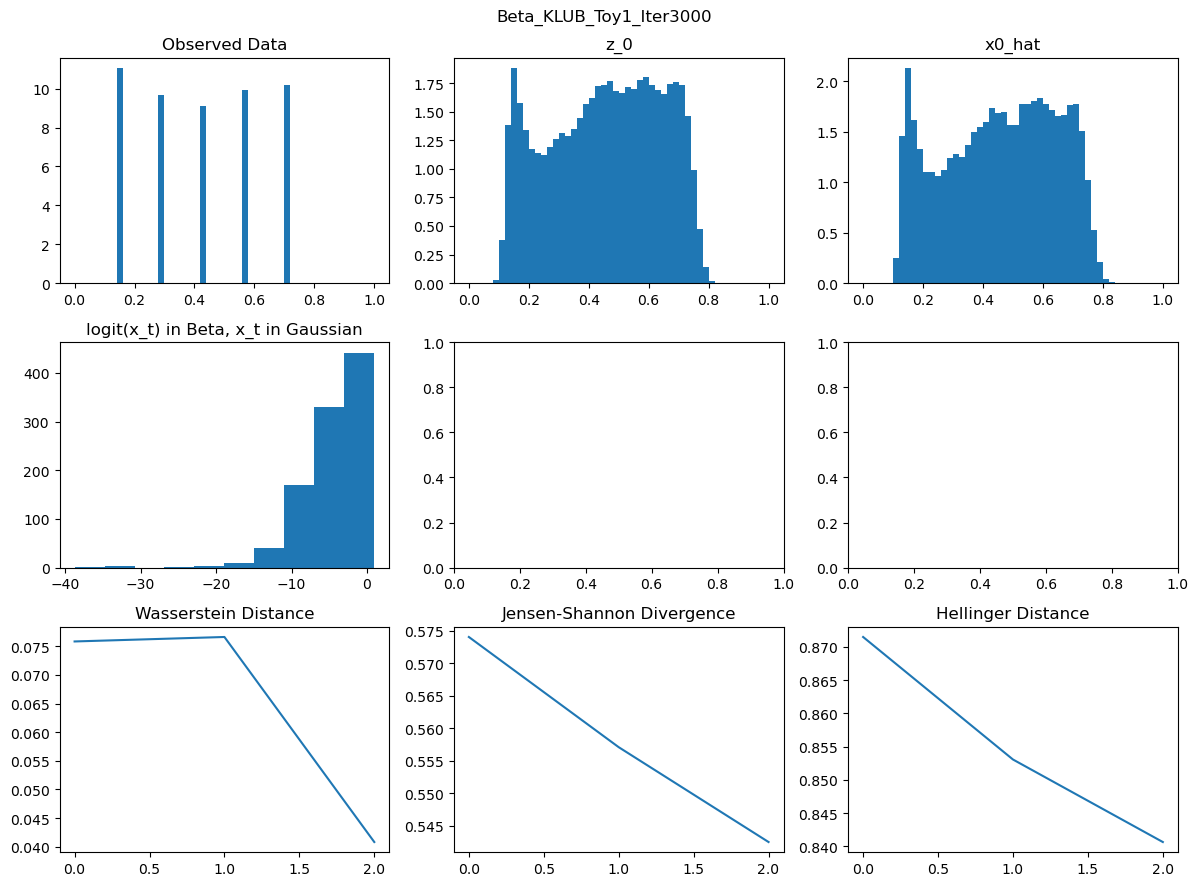

4000 tensor(0.2608, grad_fn=<MeanBackward0>)
4000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493]
4000 JSD [0.57403056 0.55709281 0.54251595 0.53666749]
4000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583]


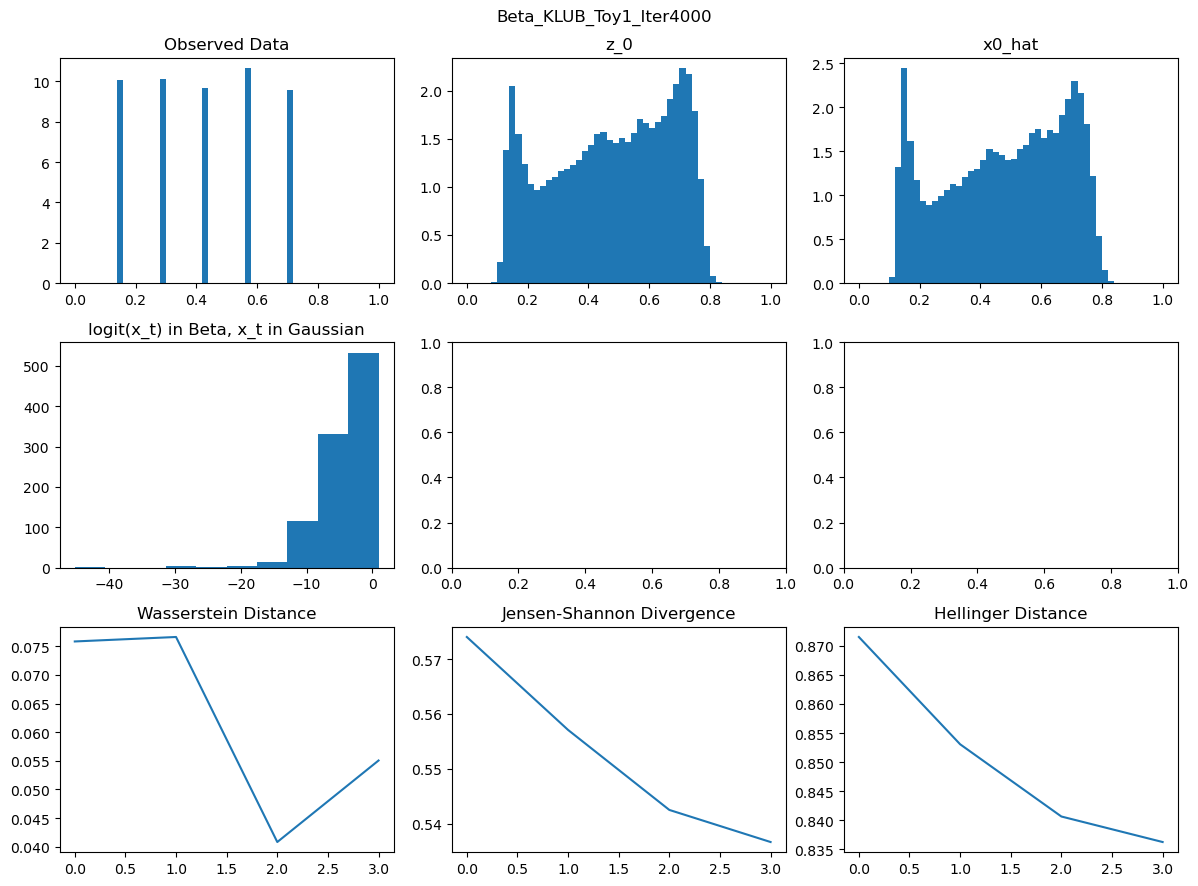

5000 tensor(0.2748, grad_fn=<MeanBackward0>)
5000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197]
5000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518]
5000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808]


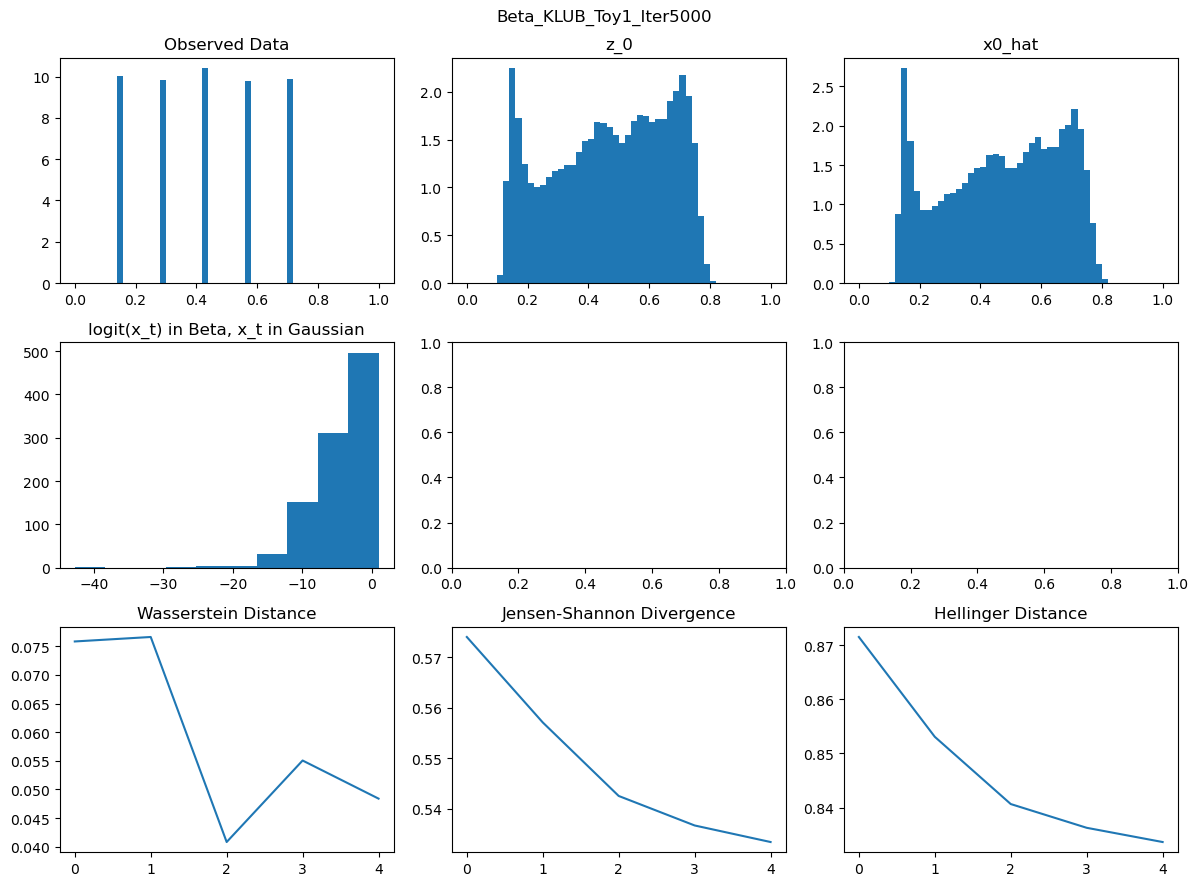

6000 tensor(0.2707, grad_fn=<MeanBackward0>)
6000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636]
6000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362]
6000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119]


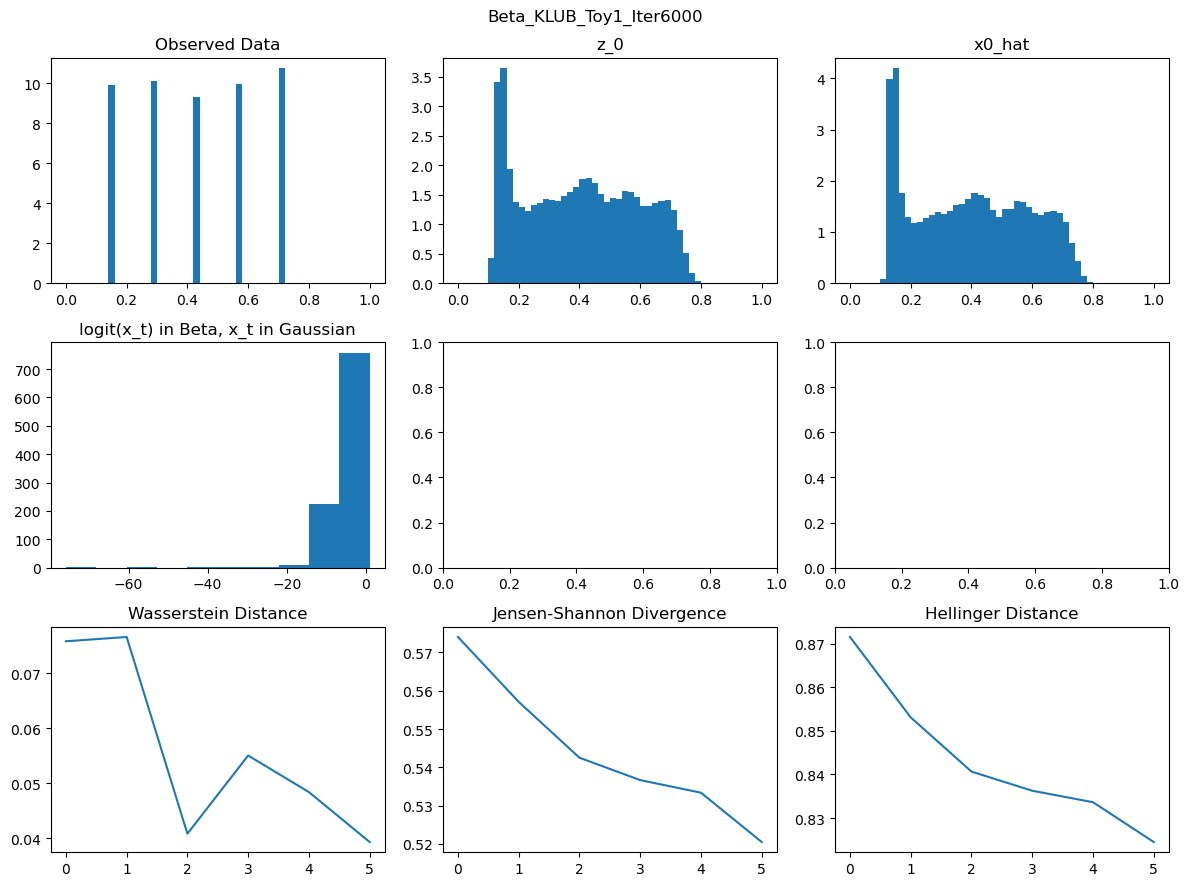

7000 tensor(0.2512, grad_fn=<MeanBackward0>)
7000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656]
7000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427]
7000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119
 0.8232164 ]


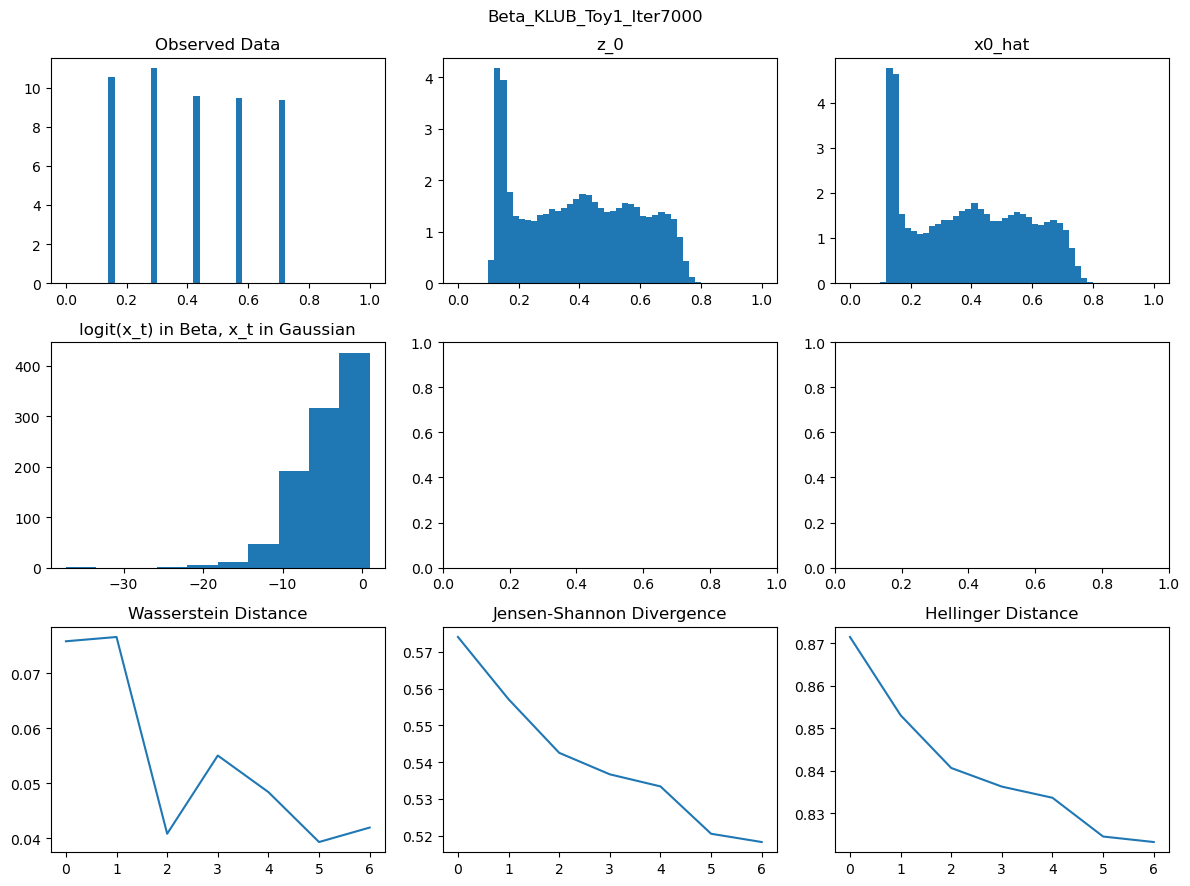

8000 tensor(0.2803, grad_fn=<MeanBackward0>)
8000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915]
8000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738 ]
8000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119
 0.8232164  0.81289448]


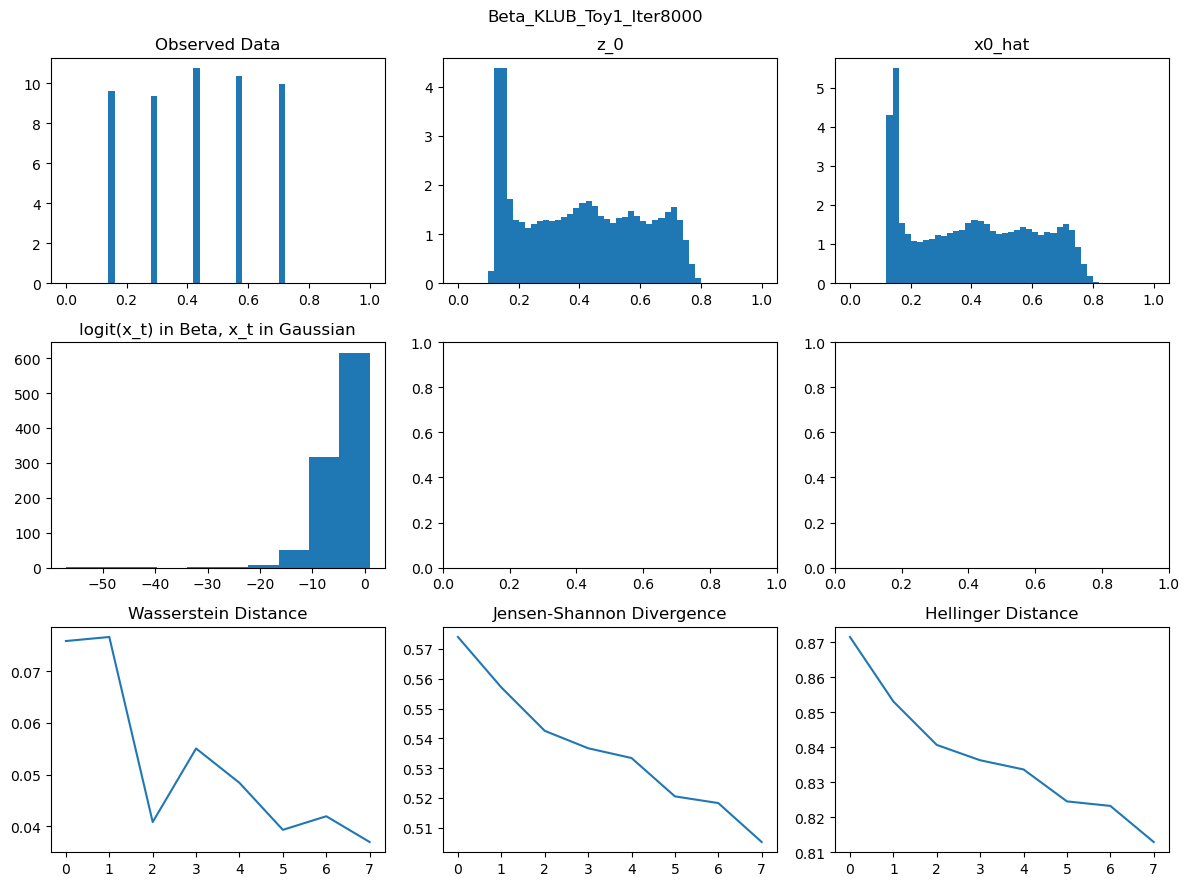

9000 tensor(0.2284, grad_fn=<MeanBackward0>)
9000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482]
9000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322]
9000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119
 0.8232164  0.81289448 0.79967945]


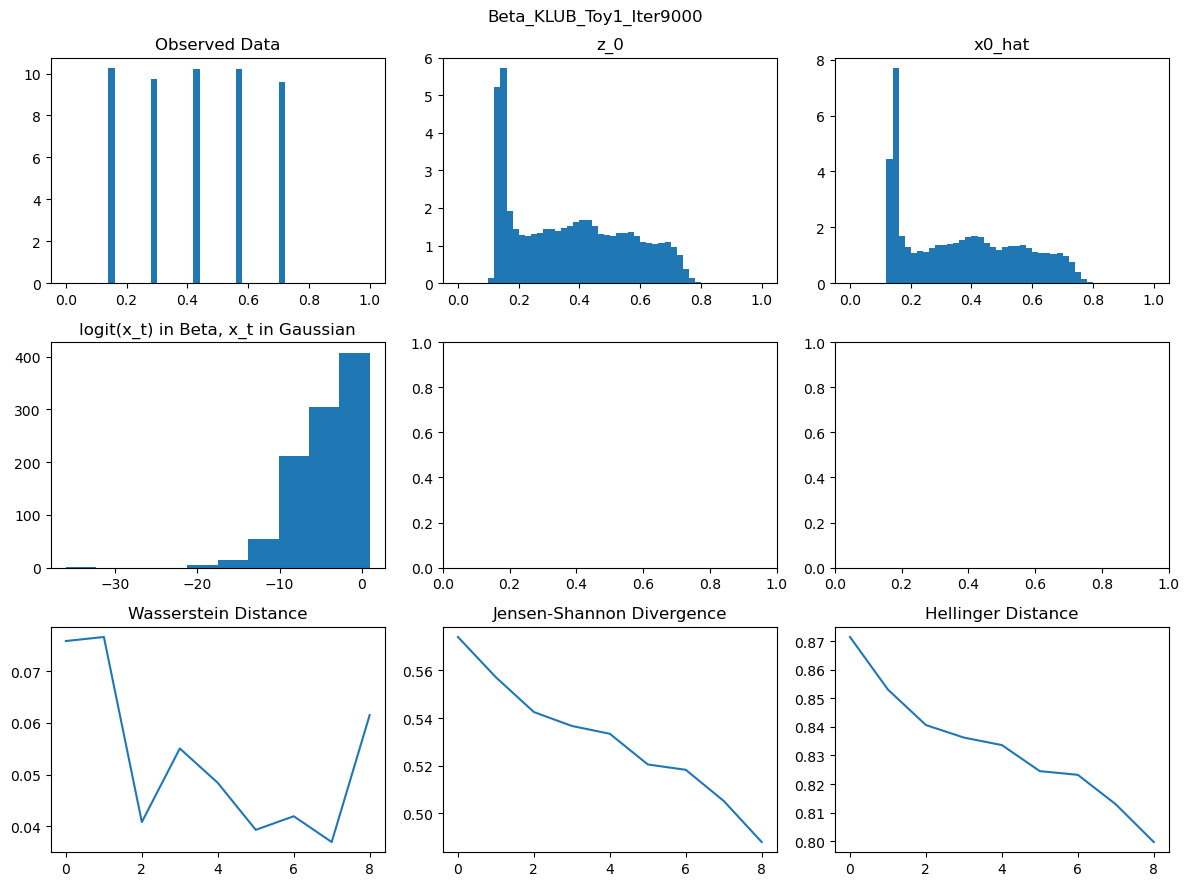

10000 tensor(0.2670, grad_fn=<MeanBackward0>)
10000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259]
10000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524 ]
10000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119
 0.8232164  0.81289448 0.79967945 0.80217853]


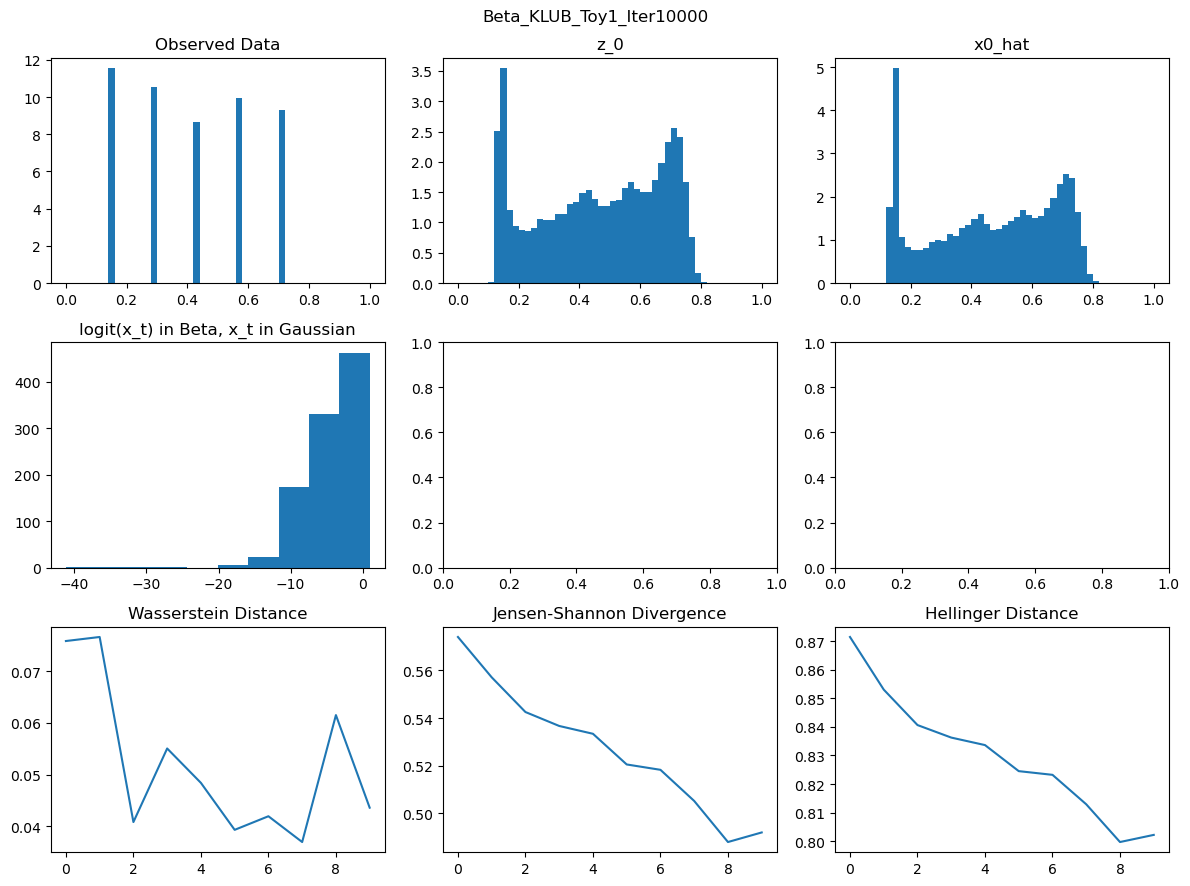

20000 tensor(0.2097, grad_fn=<MeanBackward0>)
20000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603]
20000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297 ]
20000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119
 0.8232164  0.81289448 0.79967945 0.80217853 0.6752053 ]


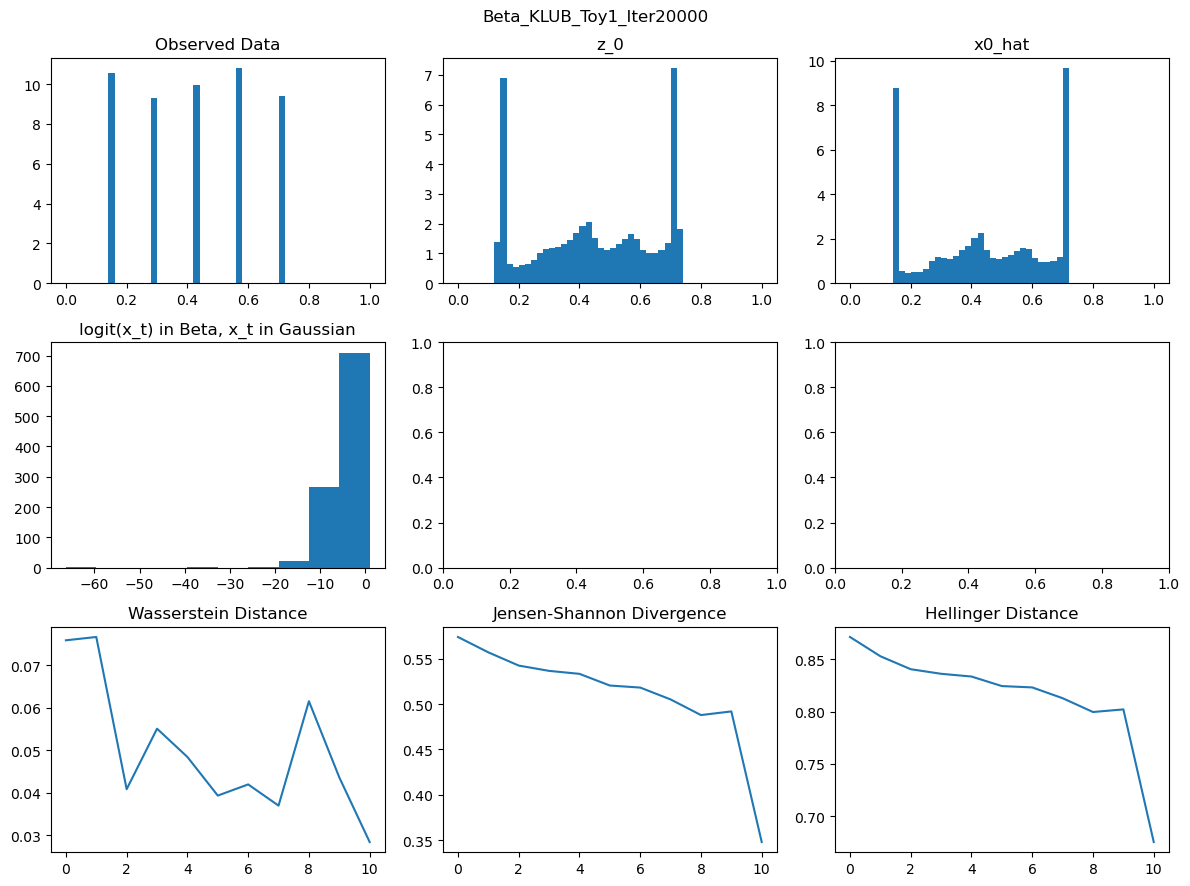

30000 tensor(0.1784, grad_fn=<MeanBackward0>)
30000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629]
30000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989]
30000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119
 0.8232164  0.81289448 0.79967945 0.80217853 0.6752053  0.60722308]


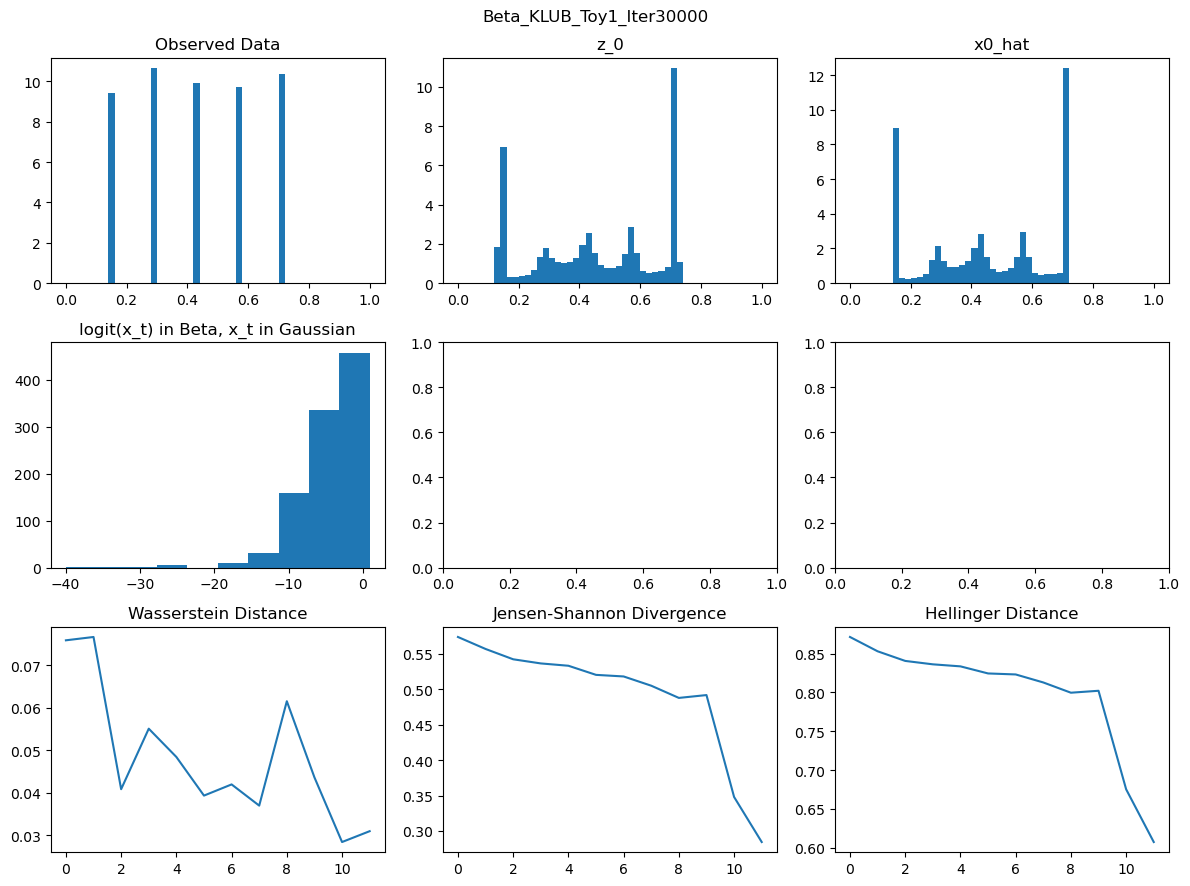

40000 tensor(0.1535, grad_fn=<MeanBackward0>)
40000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634]
40000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814]
40000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119
 0.8232164  0.81289448 0.79967945 0.80217853 0.6752053  0.60722308
 0.66699294]


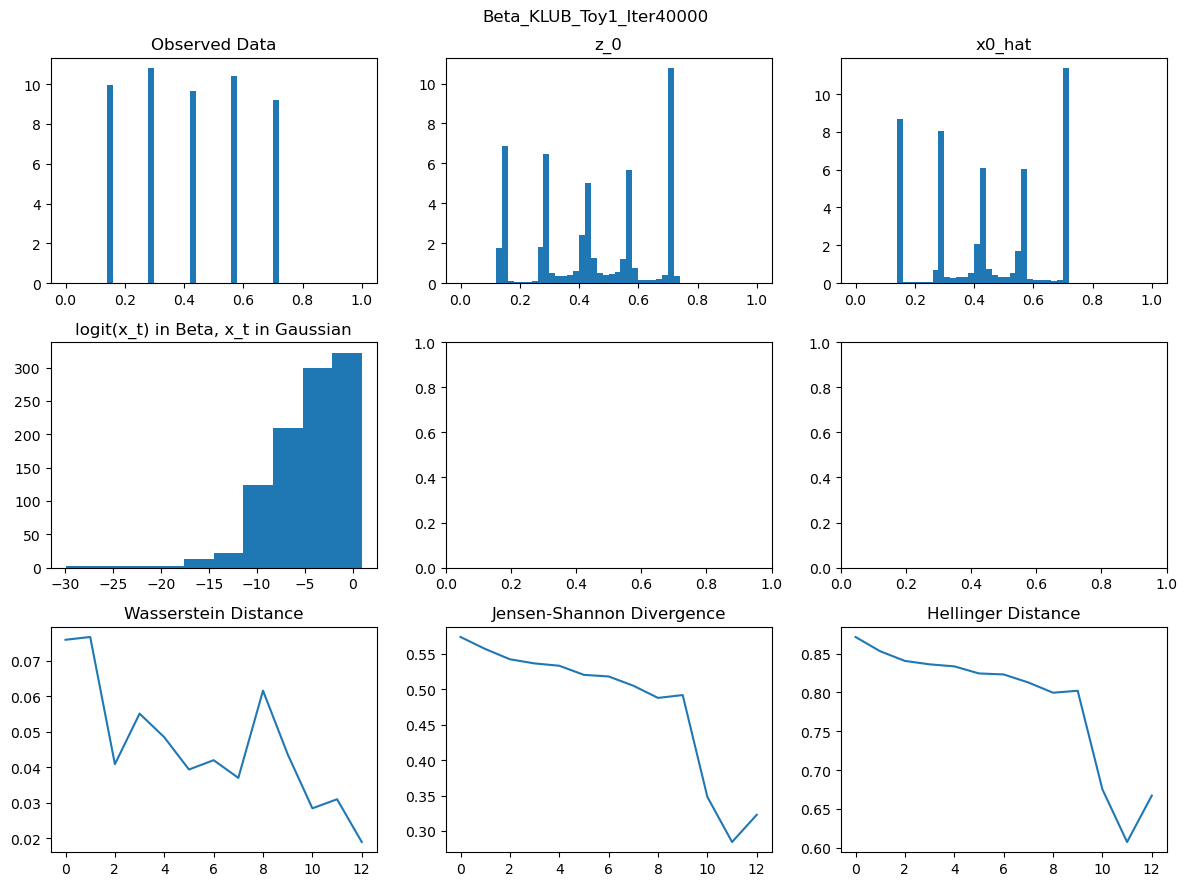

50000 tensor(0.1322, grad_fn=<MeanBackward0>)
50000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593]
50000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641]
50000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119
 0.8232164  0.81289448 0.79967945 0.80217853 0.6752053  0.60722308
 0.66699294 0.29682351]


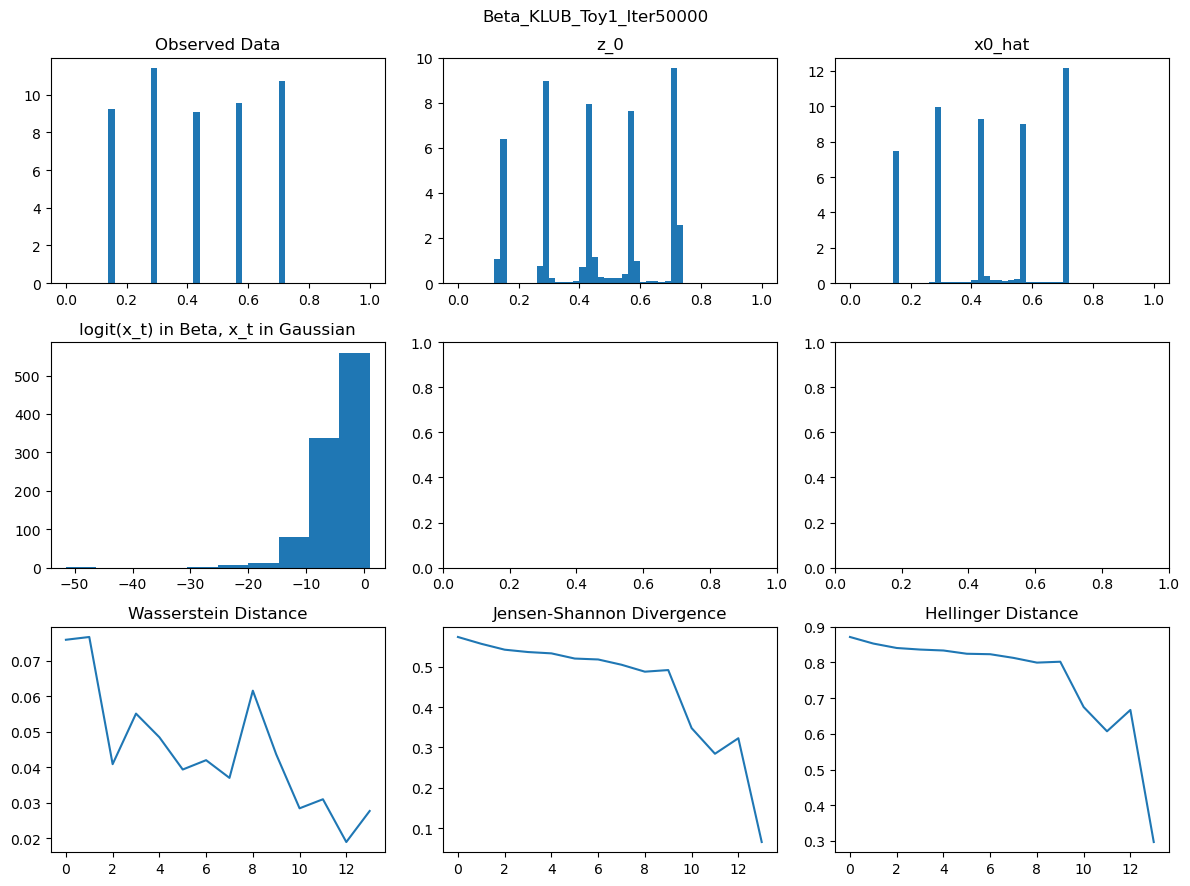

60000 tensor(0.1046, grad_fn=<MeanBackward0>)
60000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956]
60000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595]
60000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119
 0.8232164  0.81289448 0.79967945 0.80217853 0.6752053  0.60722308
 0.66699294 0.29682351 0.15000226]


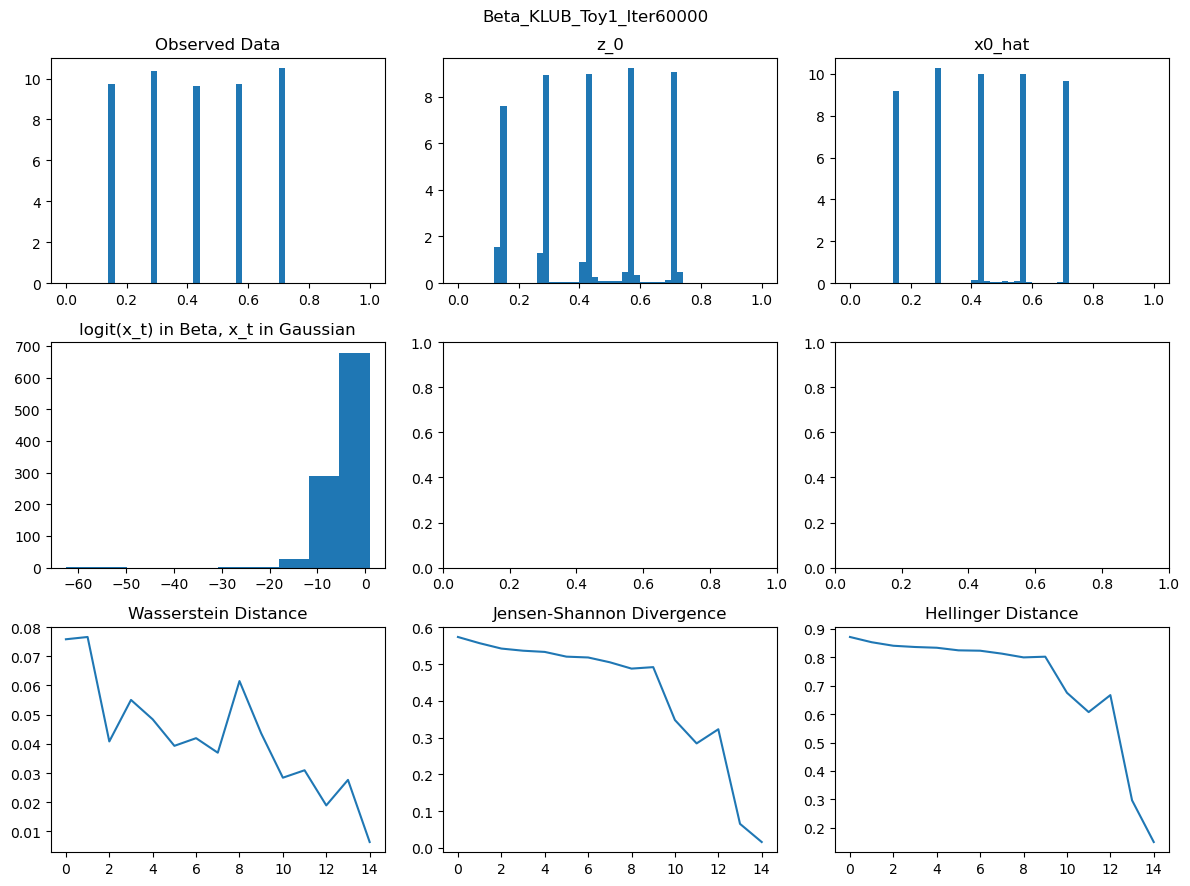

70000 tensor(0.1189, grad_fn=<MeanBackward0>)
70000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361]
70000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841]
70000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119
 0.8232164  0.81289448 0.79967945 0.80217853 0.6752053  0.60722308
 0.66699294 0.29682351 0.15000226 0.16740573]


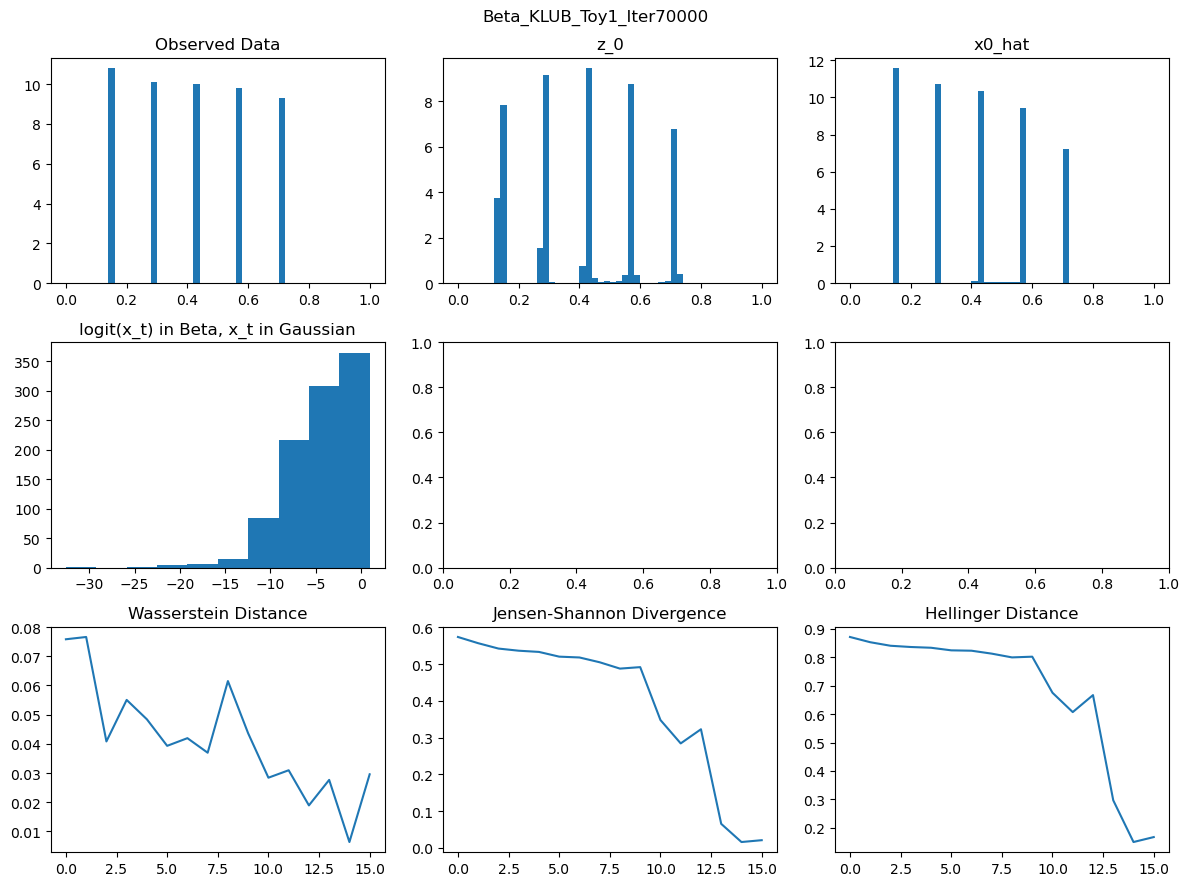

80000 tensor(0.0971, grad_fn=<MeanBackward0>)
80000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223 ]
80000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074]
80000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119
 0.8232164  0.81289448 0.79967945 0.80217853 0.6752053  0.60722308
 0.66699294 0.29682351 0.15000226 0.16740573 0.17375037]


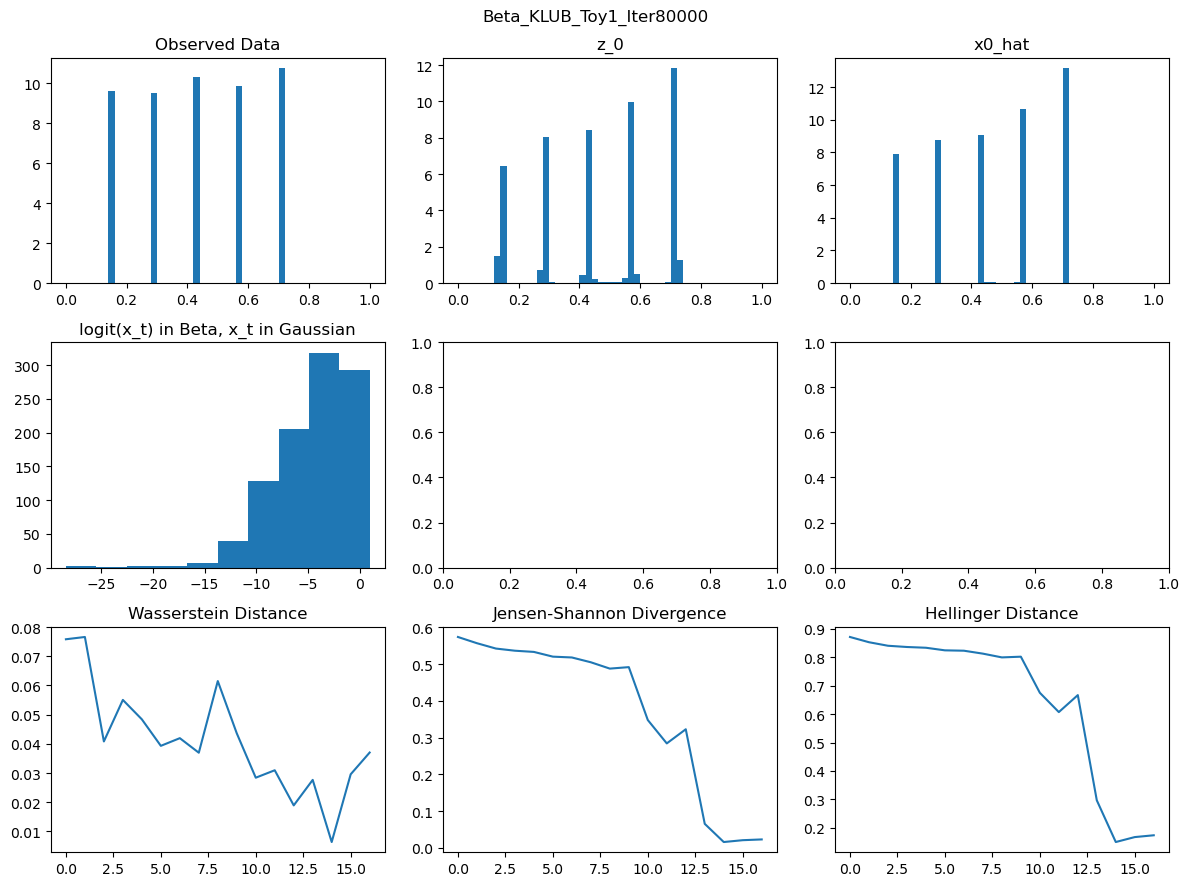

90000 tensor(0.1145, grad_fn=<MeanBackward0>)
90000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065]
90000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065]
90000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119
 0.8232164  0.81289448 0.79967945 0.80217853 0.6752053  0.60722308
 0.66699294 0.29682351 0.15000226 0.16740573 0.17375037 0.14170406]


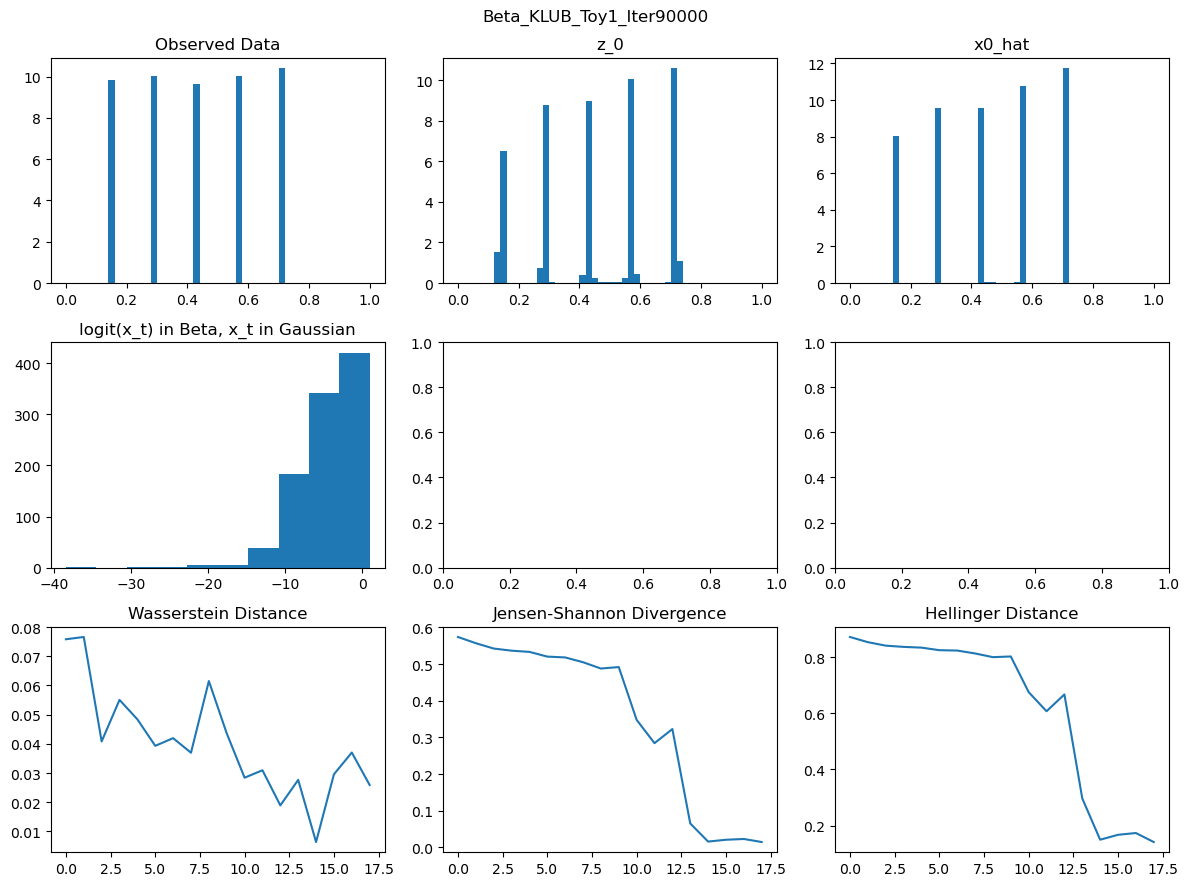

100000 tensor(0.1089, grad_fn=<MeanBackward0>)
100000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065
 0.0352988 ]
100000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065
 0.01944626]
100000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119
 0.8232164  0.81289448 0.79967945 0.80217853 0.6752053  0.60722308
 0.66699294 0.29682351 0.15000226 0.16740573 0.17375037 0.14170406
 0.16041654]


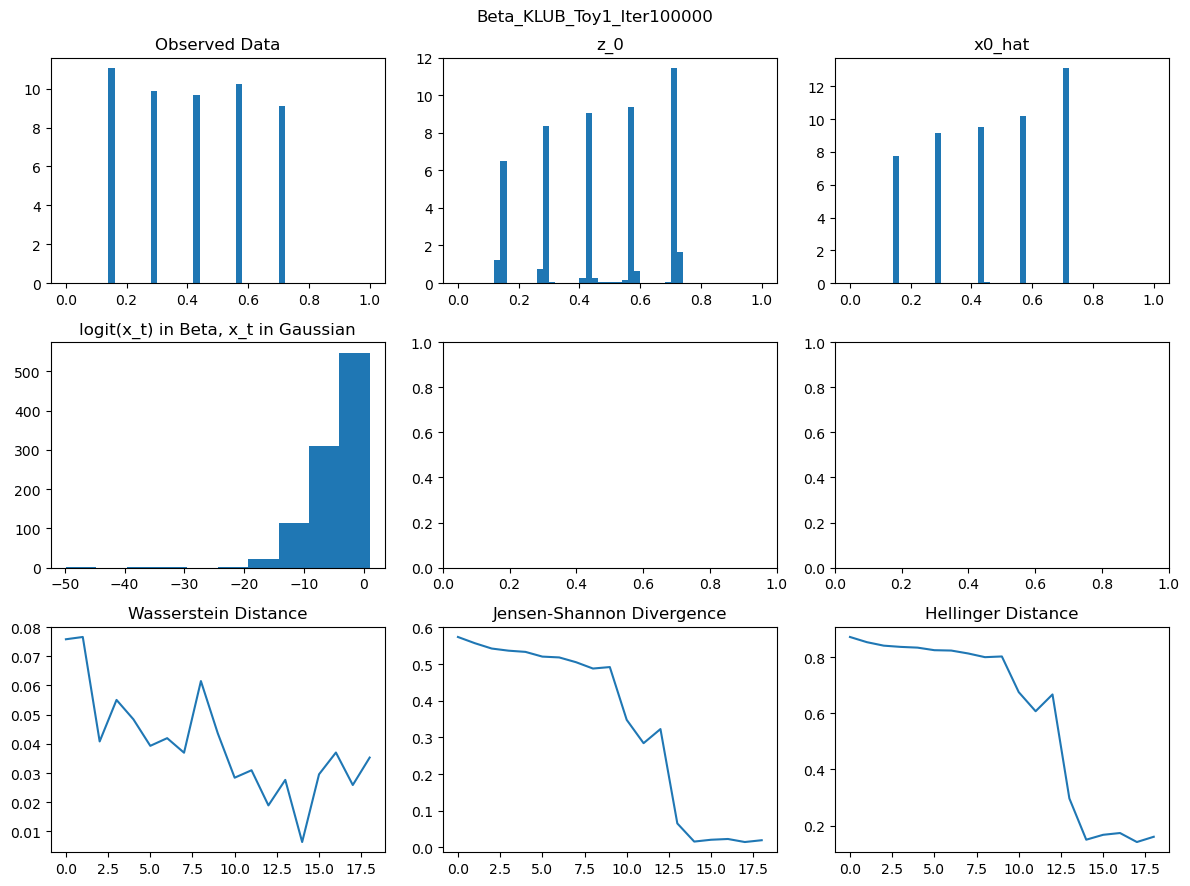

110000 tensor(0.1204, grad_fn=<MeanBackward0>)
110000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065
 0.0352988  0.01372386]
110000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065
 0.01944626 0.00874669]
110000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119
 0.8232164  0.81289448 0.79967945 0.80217853 0.6752053  0.60722308
 0.66699294 0.29682351 0.15000226 0.16740573 0.17375037 0.14170406
 0.16041654 0.11082378]


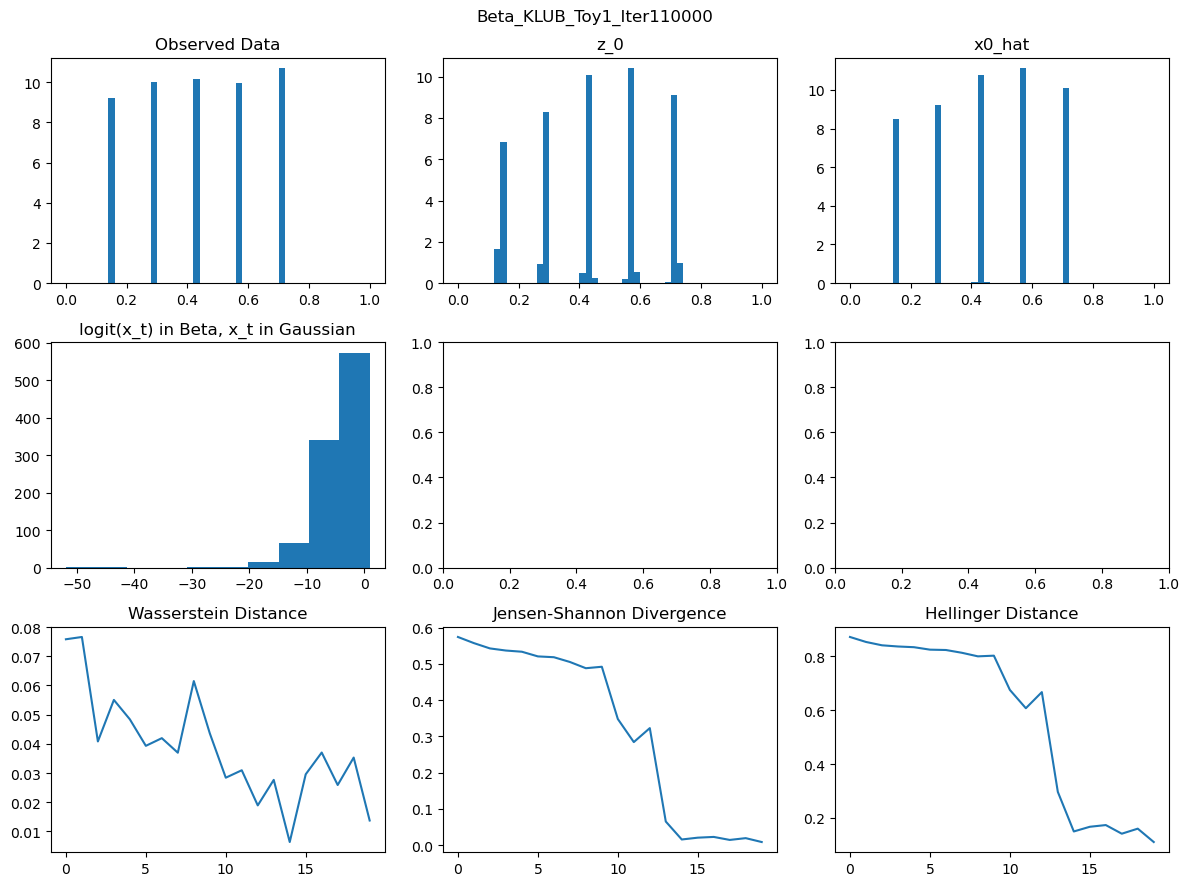

120000 tensor(0.1131, grad_fn=<MeanBackward0>)
120000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065
 0.0352988  0.01372386 0.00473645]
120000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065
 0.01944626 0.00874669 0.00501089]
120000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119
 0.8232164  0.81289448 0.79967945 0.80217853 0.6752053  0.60722308
 0.66699294 0.29682351 0.15000226 0.16740573 0.17375037 0.14170406
 0.16041654 0.11082378 0.08347878]


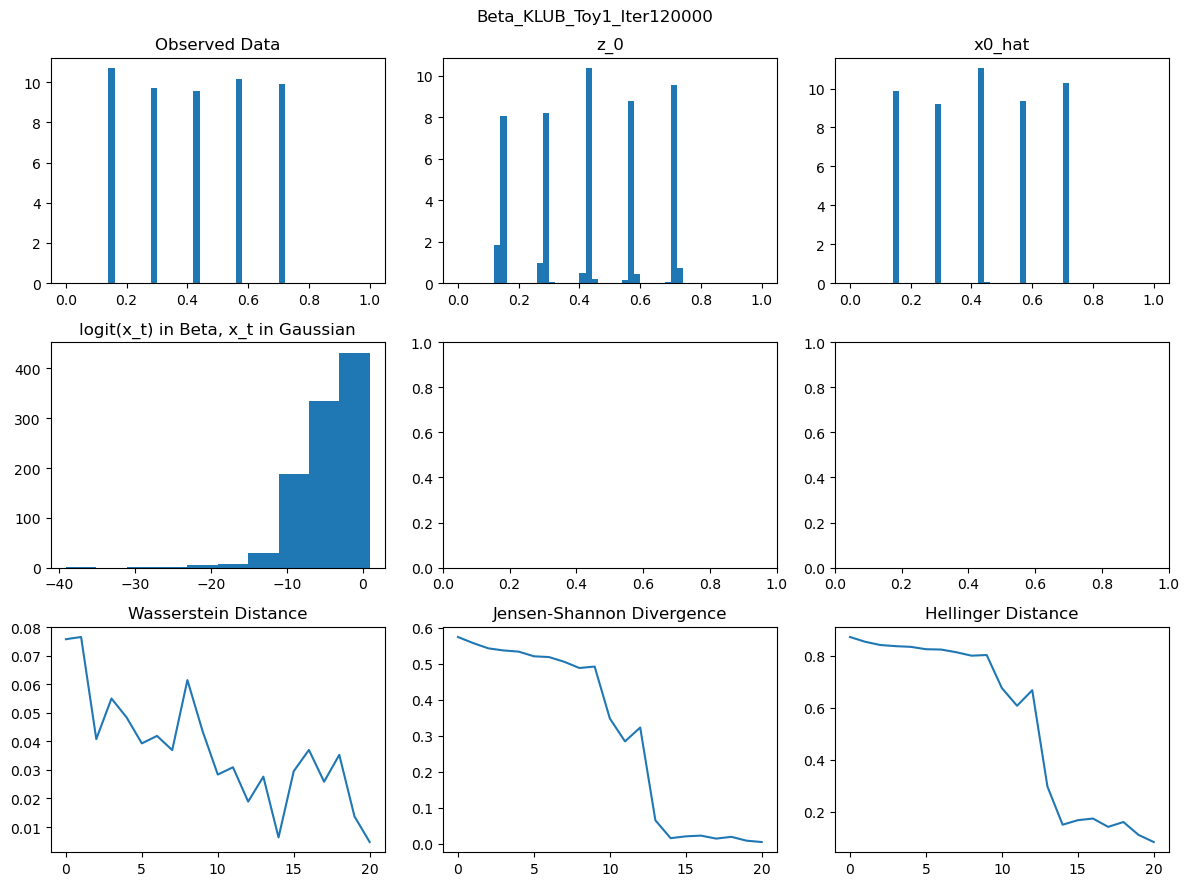

130000 tensor(0.1124, grad_fn=<MeanBackward0>)
130000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065
 0.0352988  0.01372386 0.00473645 0.03141224]
130000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065
 0.01944626 0.00874669 0.00501089 0.00779572]
130000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119
 0.8232164  0.81289448 0.79967945 0.80217853 0.6752053  0.60722308
 0.66699294 0.29682351 0.15000226 0.16740573 0.17375037 0.14170406
 0.16041654 0.11082378 0.08347878 0.09951735]


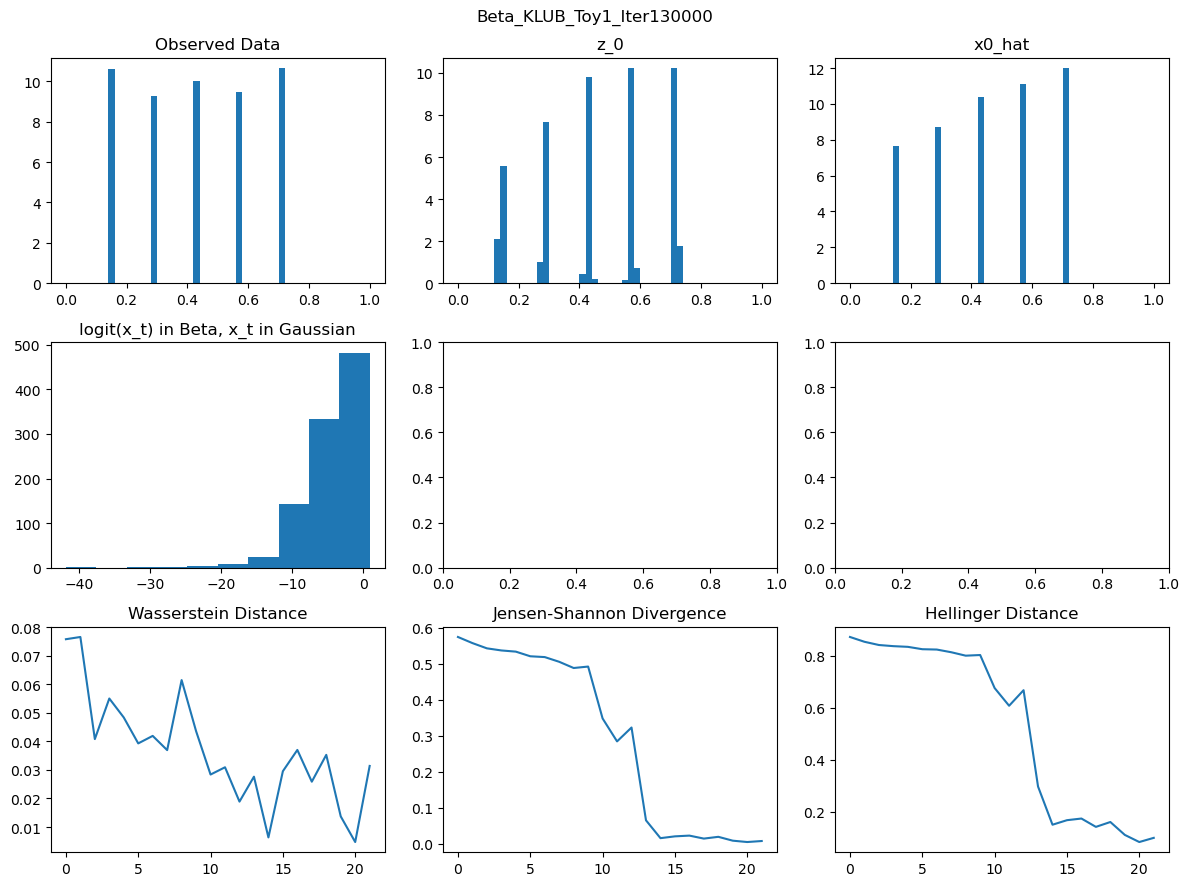

140000 tensor(0.1018, grad_fn=<MeanBackward0>)
140000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065
 0.0352988  0.01372386 0.00473645 0.03141224 0.01138221]
140000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065
 0.01944626 0.00874669 0.00501089 0.00779572 0.00328969]
140000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119
 0.8232164  0.81289448 0.79967945 0.80217853 0.6752053  0.60722308
 0.66699294 0.29682351 0.15000226 0.16740573 0.17375037 0.14170406
 0.16041654 0.11082378 0.08347878 0.09951735 0.06579482]


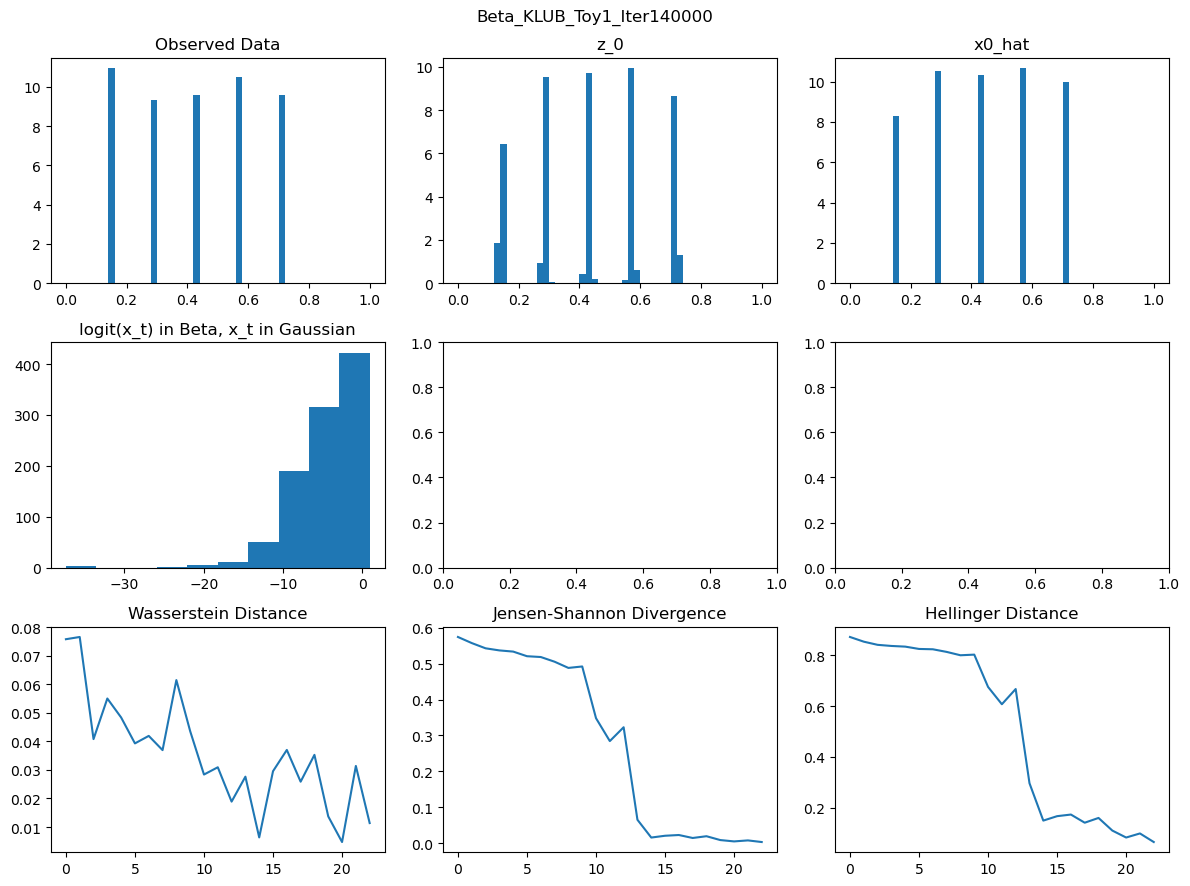

150000 tensor(0.1096, grad_fn=<MeanBackward0>)
150000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065
 0.0352988  0.01372386 0.00473645 0.03141224 0.01138221 0.01811088]
150000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065
 0.01944626 0.00874669 0.00501089 0.00779572 0.00328969 0.13149794]
150000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119
 0.8232164  0.81289448 0.79967945 0.80217853 0.6752053  0.60722308
 0.66699294 0.29682351 0.15000226 0.16740573 0.17375037 0.14170406
 0.16041654 0.11082378 0.08347878 0.09951735 0.06579482 0.41787204]


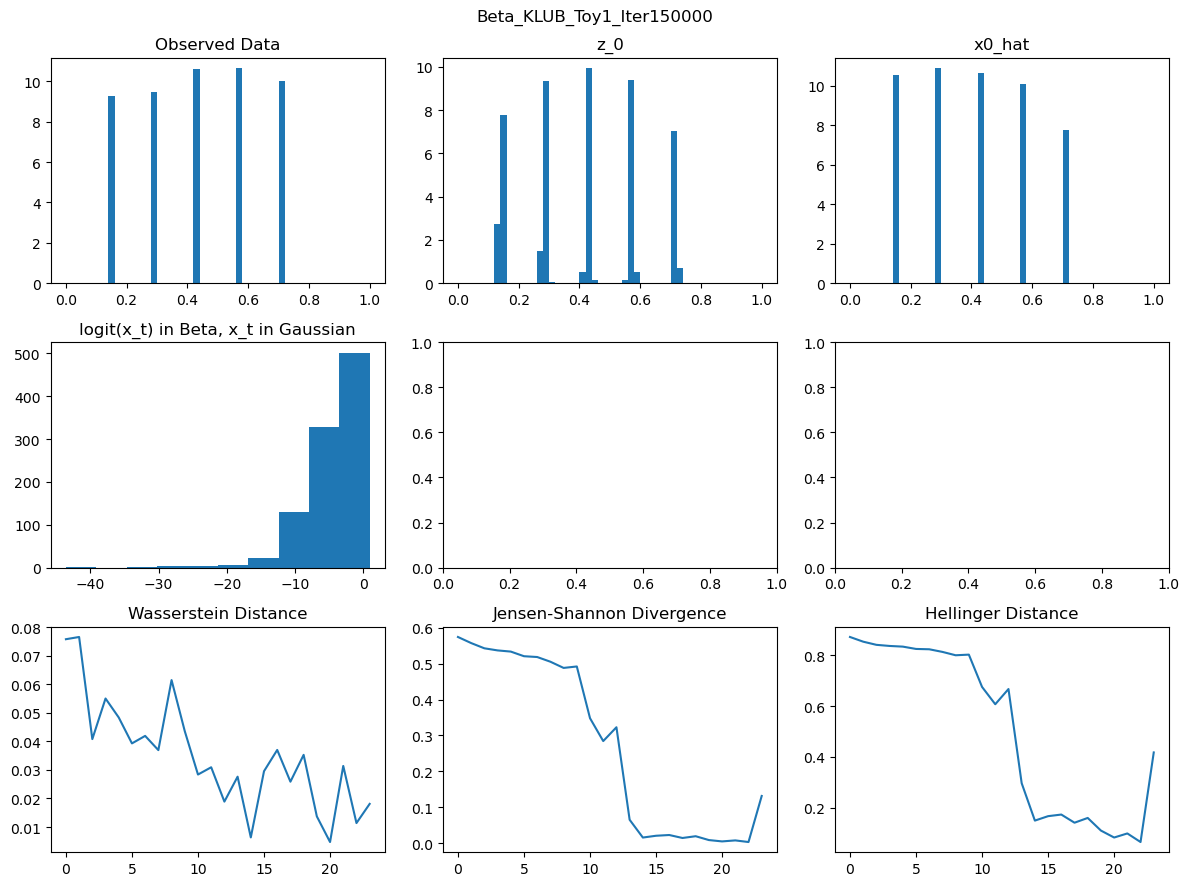

160000 tensor(0.0954, grad_fn=<MeanBackward0>)
160000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065
 0.0352988  0.01372386 0.00473645 0.03141224 0.01138221 0.01811088
 0.02443885]
160000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065
 0.01944626 0.00874669 0.00501089 0.00779572 0.00328969 0.13149794
 0.00472503]
160000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119
 0.8232164  0.81289448 0.79967945 0.80217853 0.6752053  0.60722308
 0.66699294 0.29682351 0.15000226 0.16740573 0.17375037 0.14170406
 0.16041654 0.11082378 0.08347878 0.09951735 0.06579482 0.41787204
 0.07641541]


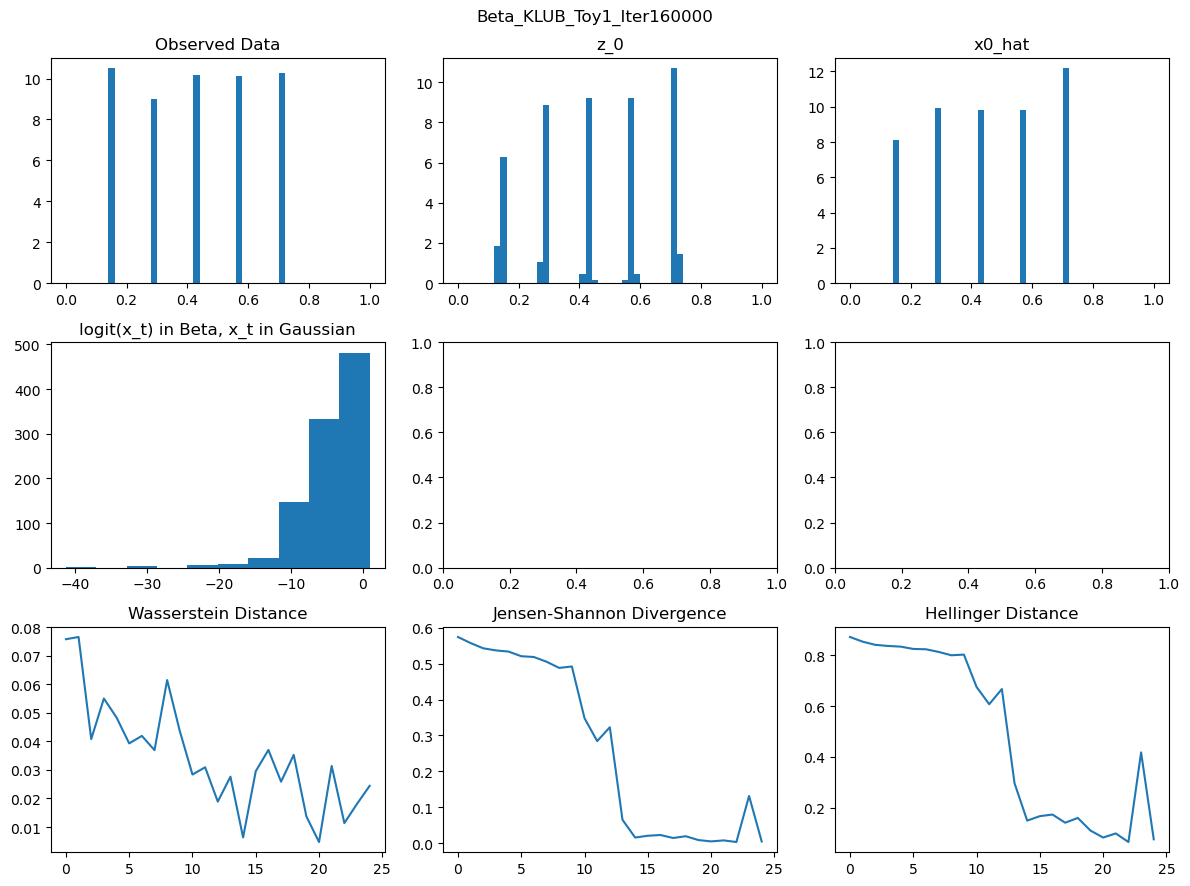

170000 tensor(0.1082, grad_fn=<MeanBackward0>)
170000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065
 0.0352988  0.01372386 0.00473645 0.03141224 0.01138221 0.01811088
 0.02443885 0.03354384]
170000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065
 0.01944626 0.00874669 0.00501089 0.00779572 0.00328969 0.13149794
 0.00472503 0.00539058]
170000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119
 0.8232164  0.81289448 0.79967945 0.80217853 0.6752053  0.60722308
 0.66699294 0.29682351 0.15000226 0.16740573 0.17375037 0.14170406
 0.16041654 0.11082378 0.08347878 0.09951735 0.06579482 0.41787204
 0.07641541 0.07751892]


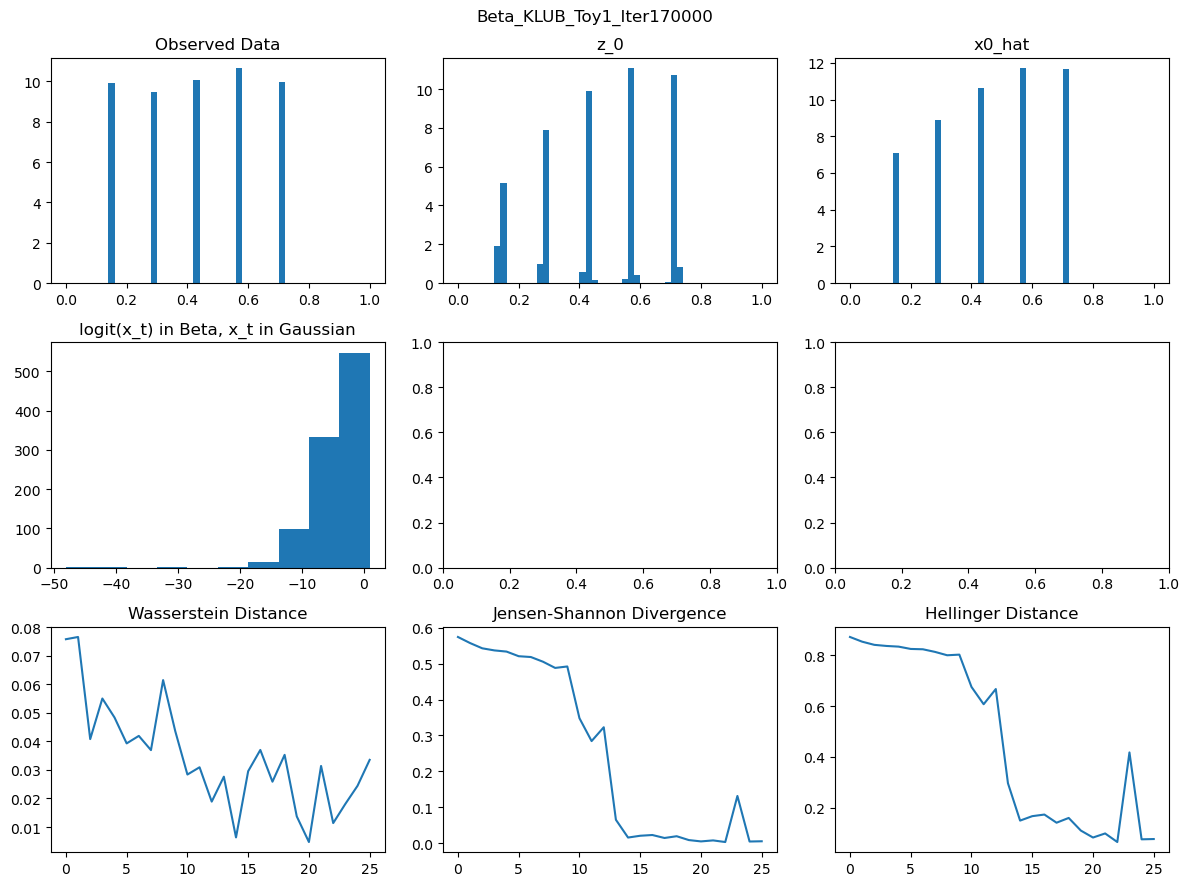

180000 tensor(0.1089, grad_fn=<MeanBackward0>)
180000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065
 0.0352988  0.01372386 0.00473645 0.03141224 0.01138221 0.01811088
 0.02443885 0.03354384 0.00440861]
180000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065
 0.01944626 0.00874669 0.00501089 0.00779572 0.00328969 0.13149794
 0.00472503 0.00539058 0.00105124]
180000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119
 0.8232164  0.81289448 0.79967945 0.80217853 0.6752053  0.60722308
 0.66699294 0.29682351 0.15000226 0.16740573 0.17375037 0.14170406
 0.16041654 0.11082378 0.08347878 0.09951735 0.06579482 0.41787204
 0.07641541 0.07751892 0.037899

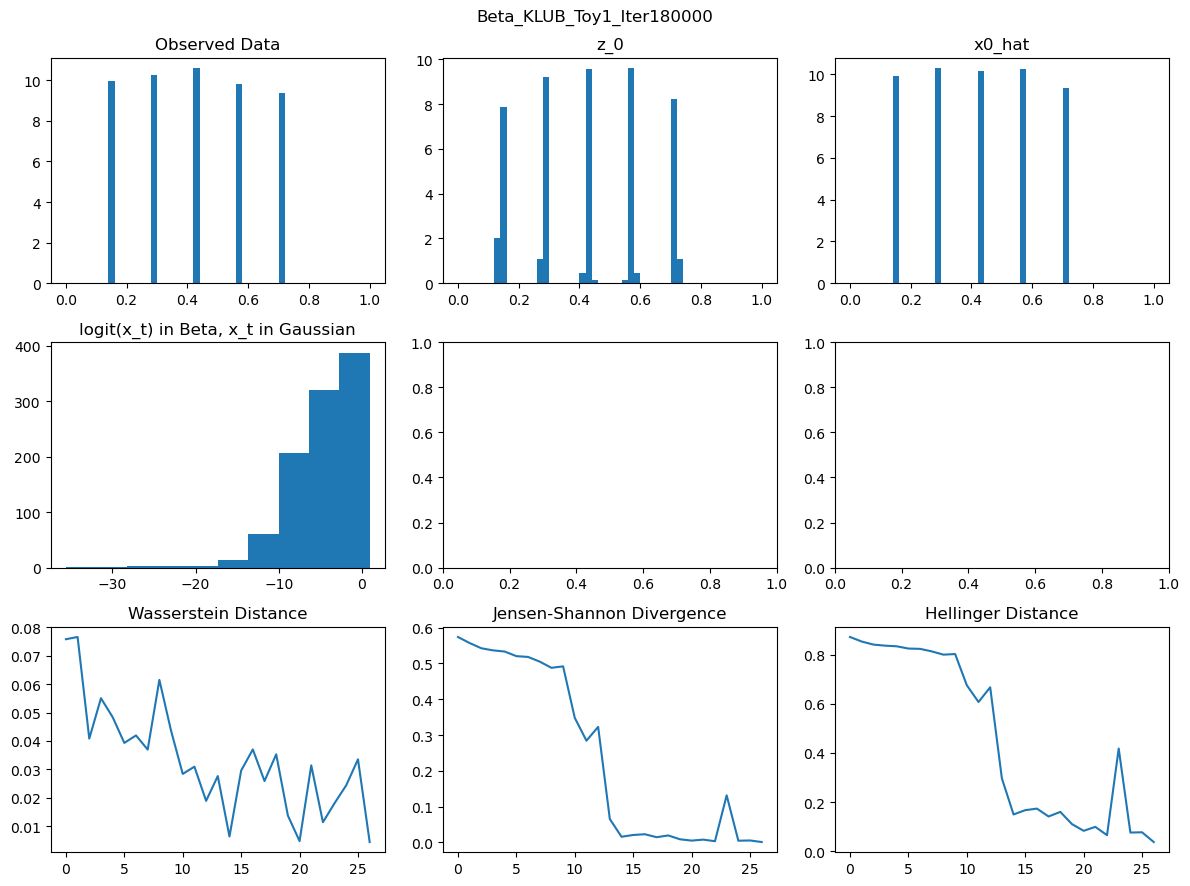

190000 tensor(0.1078, grad_fn=<MeanBackward0>)
190000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065
 0.0352988  0.01372386 0.00473645 0.03141224 0.01138221 0.01811088
 0.02443885 0.03354384 0.00440861 0.00473245]
190000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065
 0.01944626 0.00874669 0.00501089 0.00779572 0.00328969 0.13149794
 0.00472503 0.00539058 0.00105124 0.00156254]
190000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119
 0.8232164  0.81289448 0.79967945 0.80217853 0.6752053  0.60722308
 0.66699294 0.29682351 0.15000226 0.16740573 0.17375037 0.14170406
 0.16041654 0.11082378 0.08347878 0.09951735 0.06579482 0.41787204
 0.076415

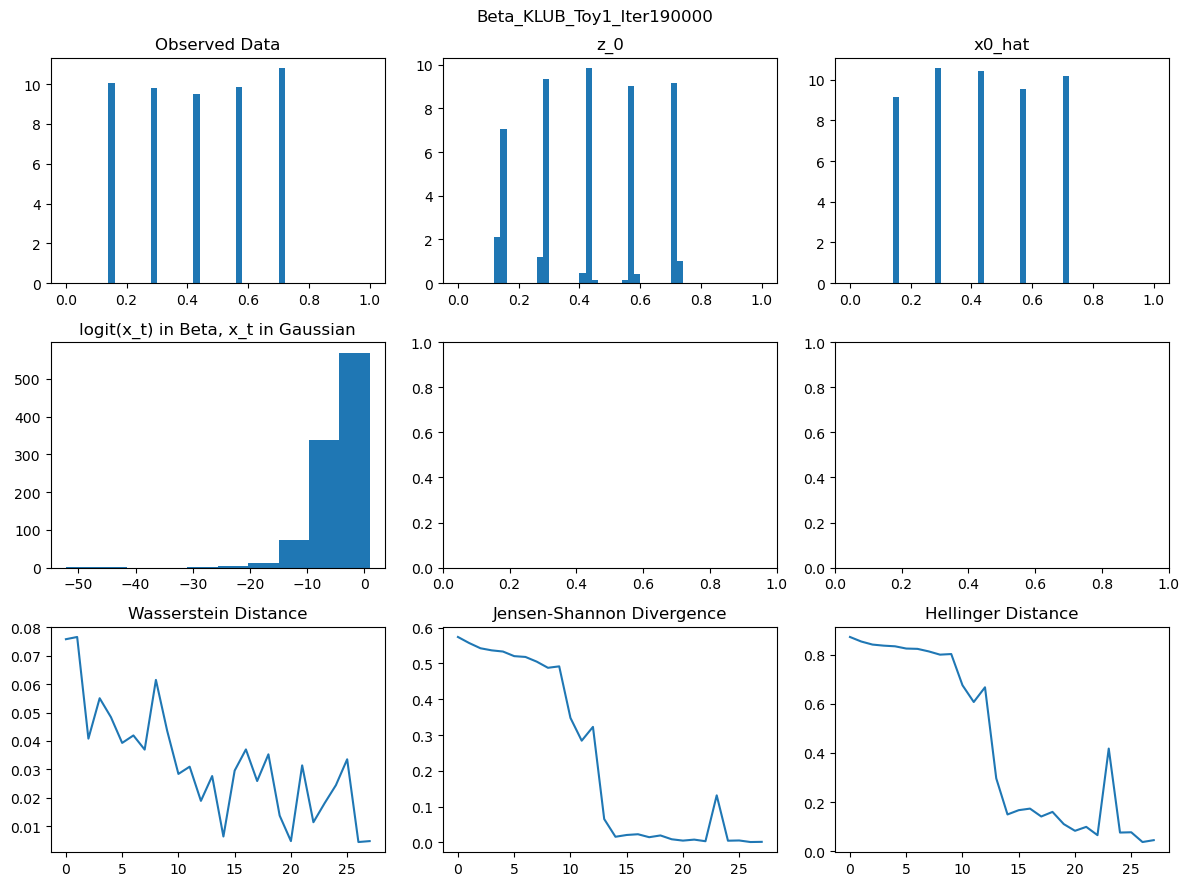

200000 tensor(0.0972, grad_fn=<MeanBackward0>)
200000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065
 0.0352988  0.01372386 0.00473645 0.03141224 0.01138221 0.01811088
 0.02443885 0.03354384 0.00440861 0.00473245 0.00560843]
200000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065
 0.01944626 0.00874669 0.00501089 0.00779572 0.00328969 0.13149794
 0.00472503 0.00539058 0.00105124 0.00156254 0.00176749]
200000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119
 0.8232164  0.81289448 0.79967945 0.80217853 0.6752053  0.60722308
 0.66699294 0.29682351 0.15000226 0.16740573 0.17375037 0.14170406
 0.16041654 0.11082378 0.08347878 0.09951735 0.0657948

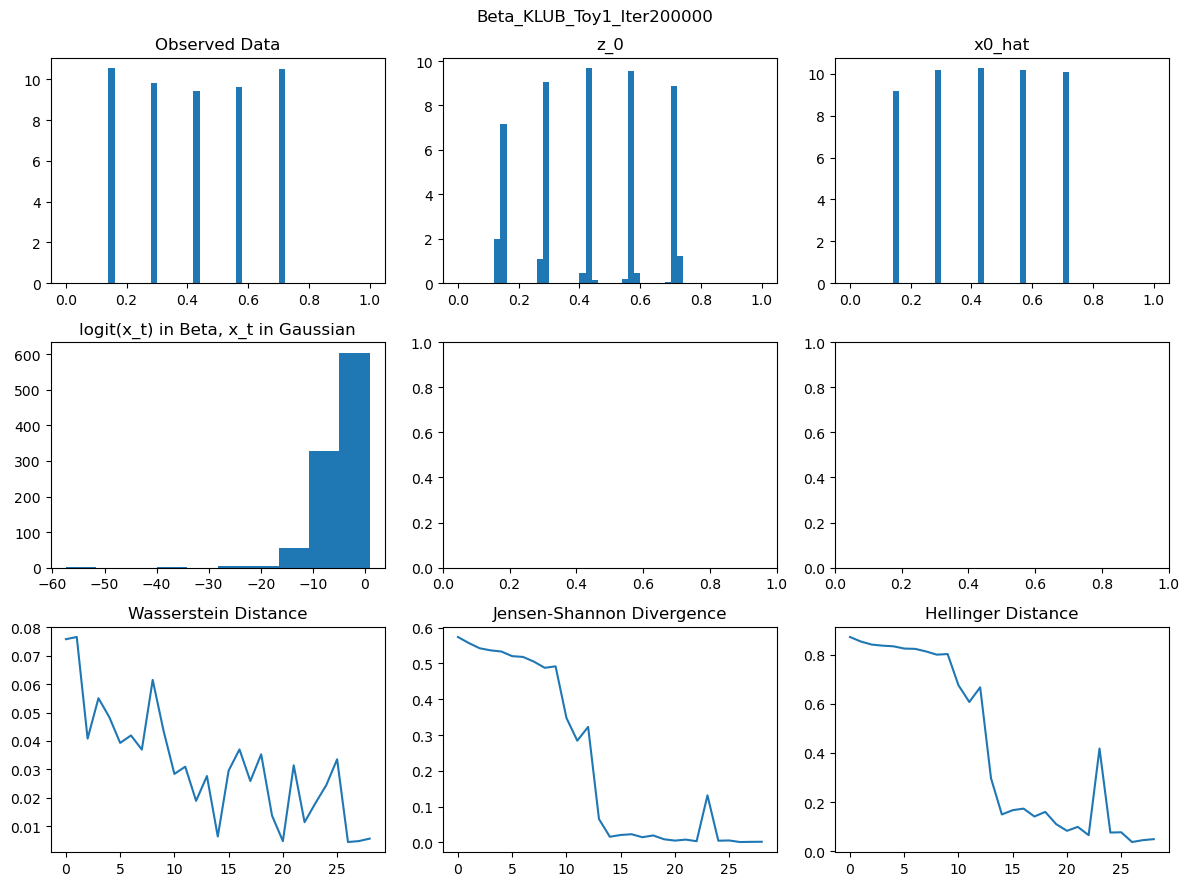

210000 tensor(0.1123, grad_fn=<MeanBackward0>)
210000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065
 0.0352988  0.01372386 0.00473645 0.03141224 0.01138221 0.01811088
 0.02443885 0.03354384 0.00440861 0.00473245 0.00560843 0.00991743]
210000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065
 0.01944626 0.00874669 0.00501089 0.00779572 0.00328969 0.13149794
 0.00472503 0.00539058 0.00105124 0.00156254 0.00176749 0.00374392]
210000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119
 0.8232164  0.81289448 0.79967945 0.80217853 0.6752053  0.60722308
 0.66699294 0.29682351 0.15000226 0.16740573 0.17375037 0.14170406
 0.16041654 0.11082378 0.0834787

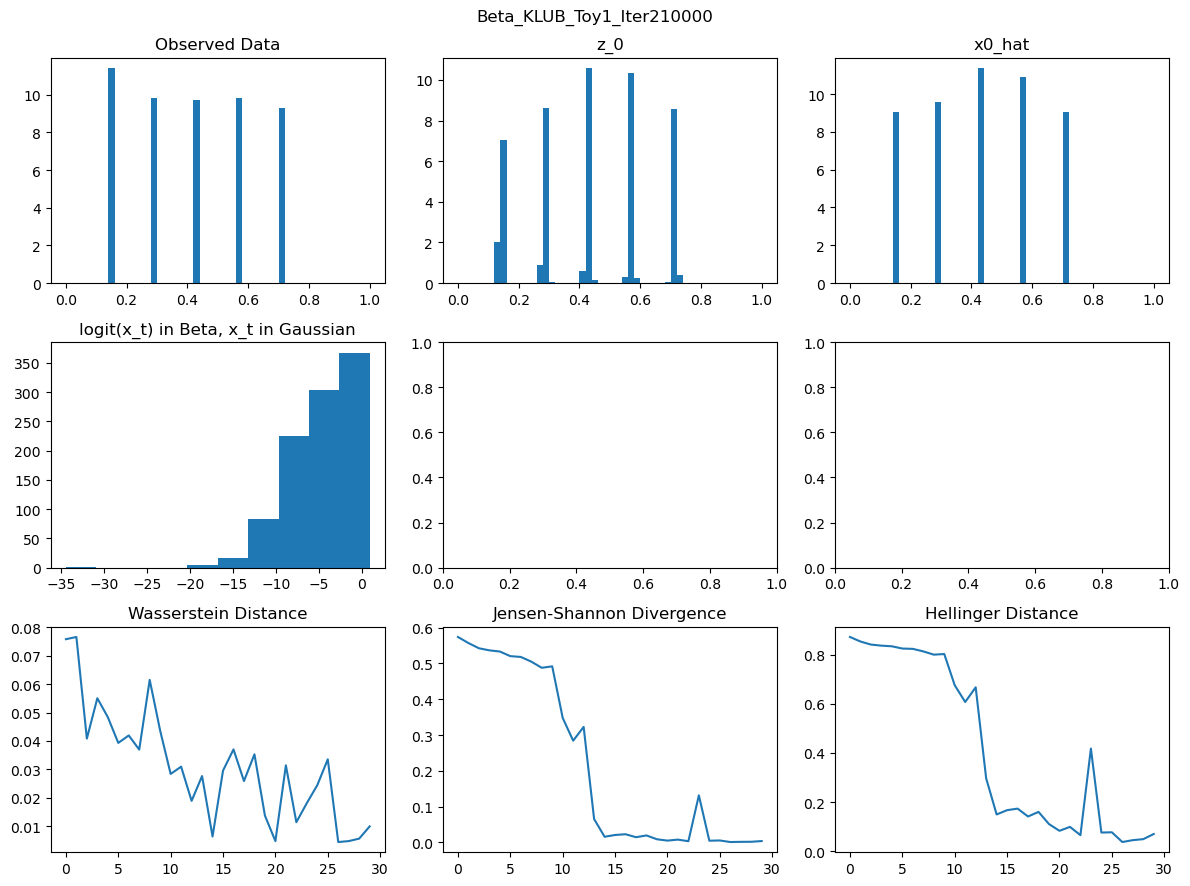

220000 tensor(0.0970, grad_fn=<MeanBackward0>)
220000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065
 0.0352988  0.01372386 0.00473645 0.03141224 0.01138221 0.01811088
 0.02443885 0.03354384 0.00440861 0.00473245 0.00560843 0.00991743
 0.01851851]
220000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065
 0.01944626 0.00874669 0.00501089 0.00779572 0.00328969 0.13149794
 0.00472503 0.00539058 0.00105124 0.00156254 0.00176749 0.00374392
 0.00232108]
220000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119
 0.8232164  0.81289448 0.79967945 0.80217853 0.6752053  0.60722308
 0.66699294 0.29682351 0.15000226 0.16740573 0.17375037 0.14170406
 0.16041

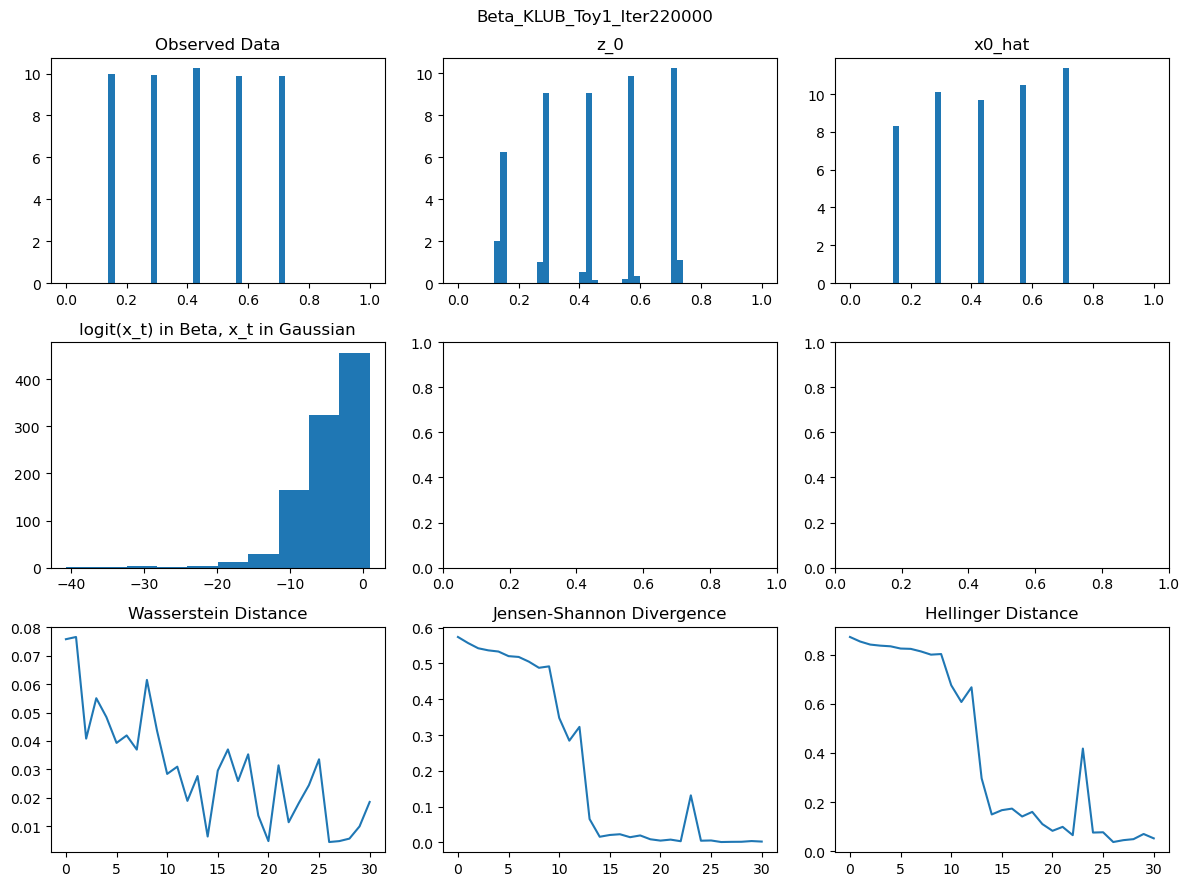

230000 tensor(0.1167, grad_fn=<MeanBackward0>)
230000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065
 0.0352988  0.01372386 0.00473645 0.03141224 0.01138221 0.01811088
 0.02443885 0.03354384 0.00440861 0.00473245 0.00560843 0.00991743
 0.01851851 0.01694372]
230000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065
 0.01944626 0.00874669 0.00501089 0.00779572 0.00328969 0.13149794
 0.00472503 0.00539058 0.00105124 0.00156254 0.00176749 0.00374392
 0.00232108 0.00227073]
230000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119
 0.8232164  0.81289448 0.79967945 0.80217853 0.6752053  0.60722308
 0.66699294 0.29682351 0.15000226 0.16740573 0.173750

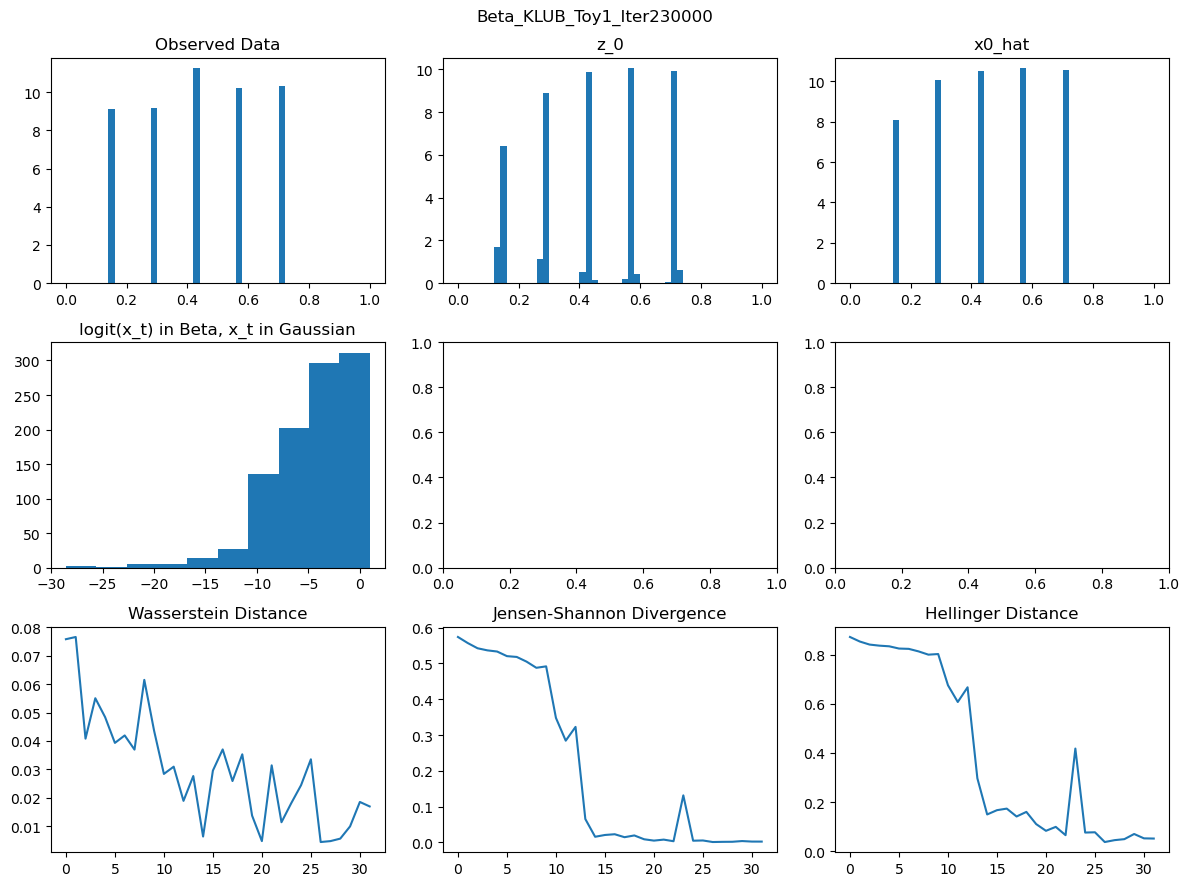

240000 tensor(0.1024, grad_fn=<MeanBackward0>)
240000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065
 0.0352988  0.01372386 0.00473645 0.03141224 0.01138221 0.01811088
 0.02443885 0.03354384 0.00440861 0.00473245 0.00560843 0.00991743
 0.01851851 0.01694372 0.04046638]
240000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065
 0.01944626 0.00874669 0.00501089 0.00779572 0.00328969 0.13149794
 0.00472503 0.00539058 0.00105124 0.00156254 0.00176749 0.00374392
 0.00232108 0.00227073 0.0059205 ]
240000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119
 0.8232164  0.81289448 0.79967945 0.80217853 0.6752053  0.60722308
 0.66699294 0.29682351 0.150002

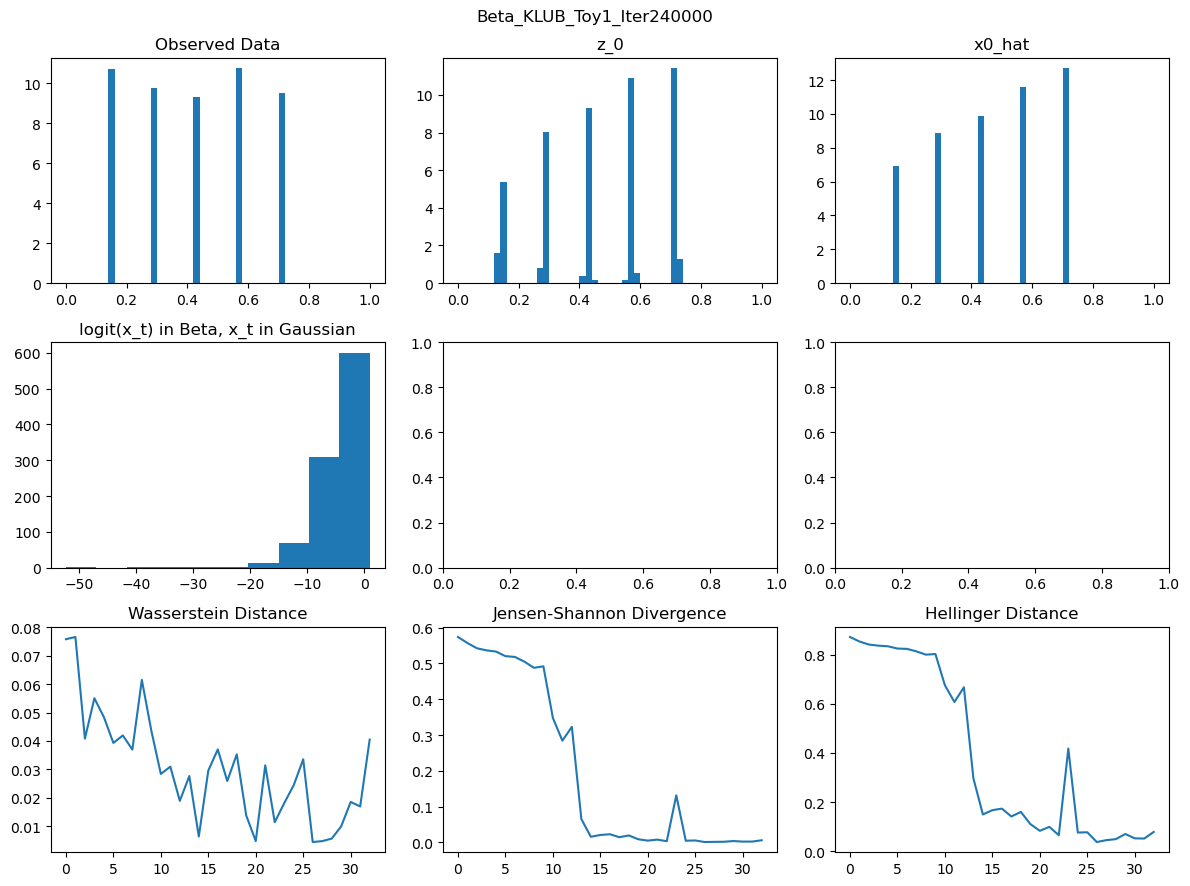

250000 tensor(0.1097, grad_fn=<MeanBackward0>)
250000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065
 0.0352988  0.01372386 0.00473645 0.03141224 0.01138221 0.01811088
 0.02443885 0.03354384 0.00440861 0.00473245 0.00560843 0.00991743
 0.01851851 0.01694372 0.04046638 0.01058327]
250000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065
 0.01944626 0.00874669 0.00501089 0.00779572 0.00328969 0.13149794
 0.00472503 0.00539058 0.00105124 0.00156254 0.00176749 0.00374392
 0.00232108 0.00227073 0.0059205  0.0010873 ]
250000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119
 0.8232164  0.81289448 0.79967945 0.80217853 0.6752053  0.60722308
 0.666992

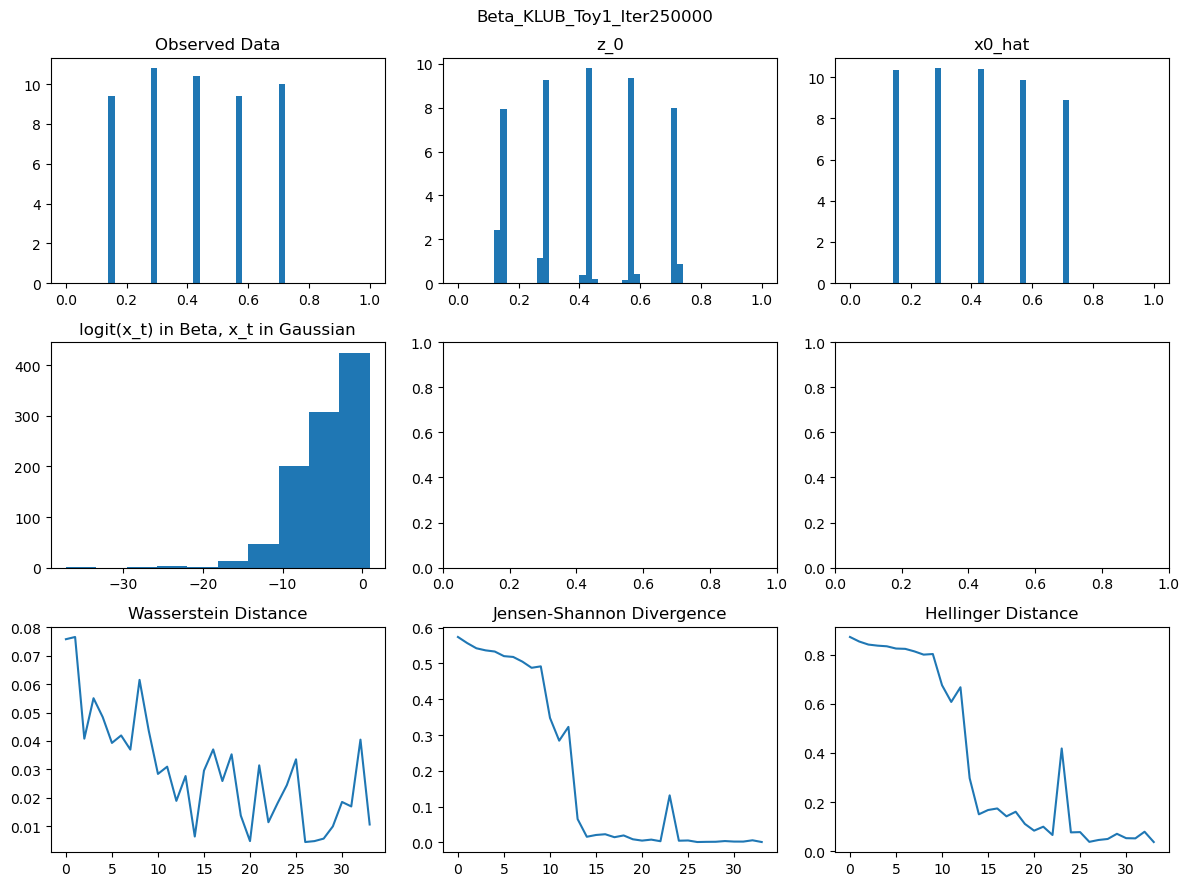

260000 tensor(0.0872, grad_fn=<MeanBackward0>)
260000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065
 0.0352988  0.01372386 0.00473645 0.03141224 0.01138221 0.01811088
 0.02443885 0.03354384 0.00440861 0.00473245 0.00560843 0.00991743
 0.01851851 0.01694372 0.04046638 0.01058327 0.00864791]
260000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065
 0.01944626 0.00874669 0.00501089 0.00779572 0.00328969 0.13149794
 0.00472503 0.00539058 0.00105124 0.00156254 0.00176749 0.00374392
 0.00232108 0.00227073 0.0059205  0.0010873  0.00118629]
260000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119
 0.8232164  0.81289448 0.79967945 0.80217853 0.6752053

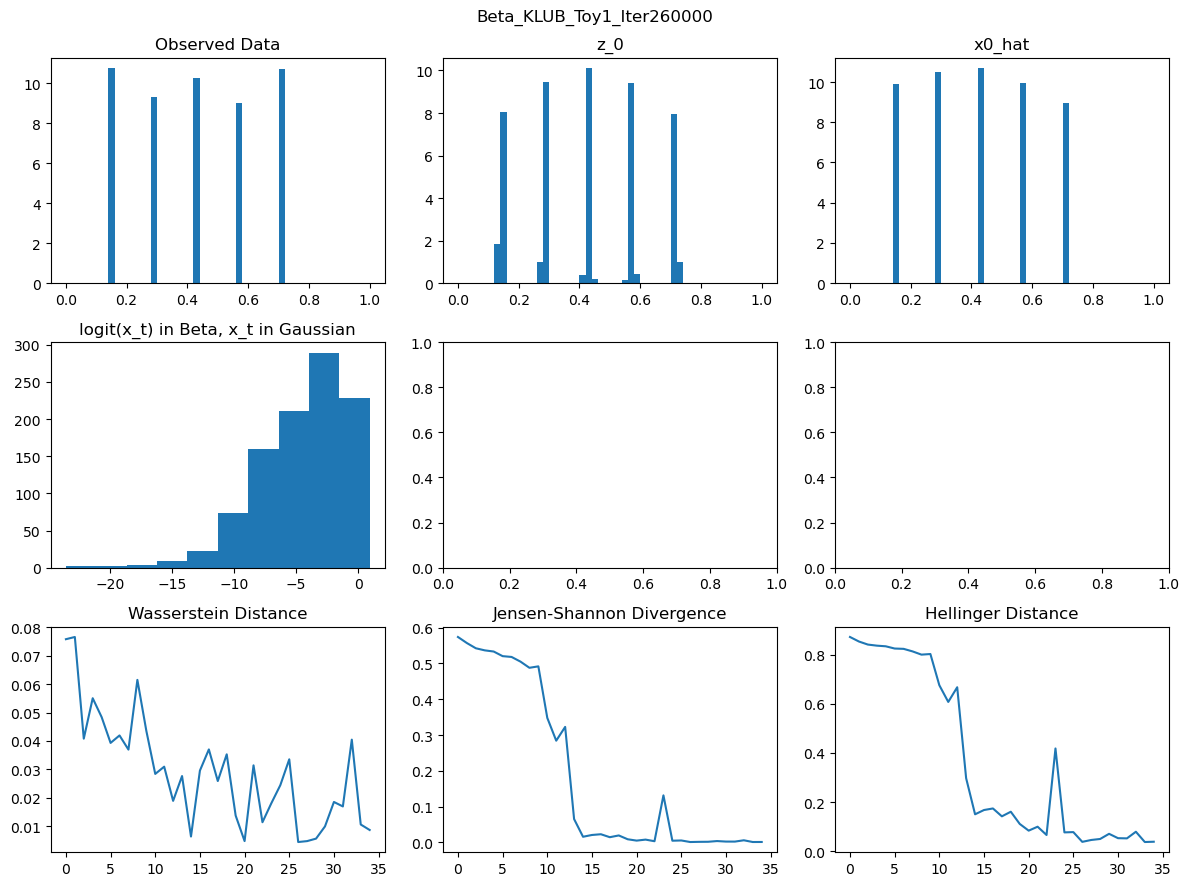

270000 tensor(0.0761, grad_fn=<MeanBackward0>)
270000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065
 0.0352988  0.01372386 0.00473645 0.03141224 0.01138221 0.01811088
 0.02443885 0.03354384 0.00440861 0.00473245 0.00560843 0.00991743
 0.01851851 0.01694372 0.04046638 0.01058327 0.00864791 0.01937367]
270000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065
 0.01944626 0.00874669 0.00501089 0.00779572 0.00328969 0.13149794
 0.00472503 0.00539058 0.00105124 0.00156254 0.00176749 0.00374392
 0.00232108 0.00227073 0.0059205  0.0010873  0.00118629 0.00310376]
270000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119
 0.8232164  0.81289448 0.7996794

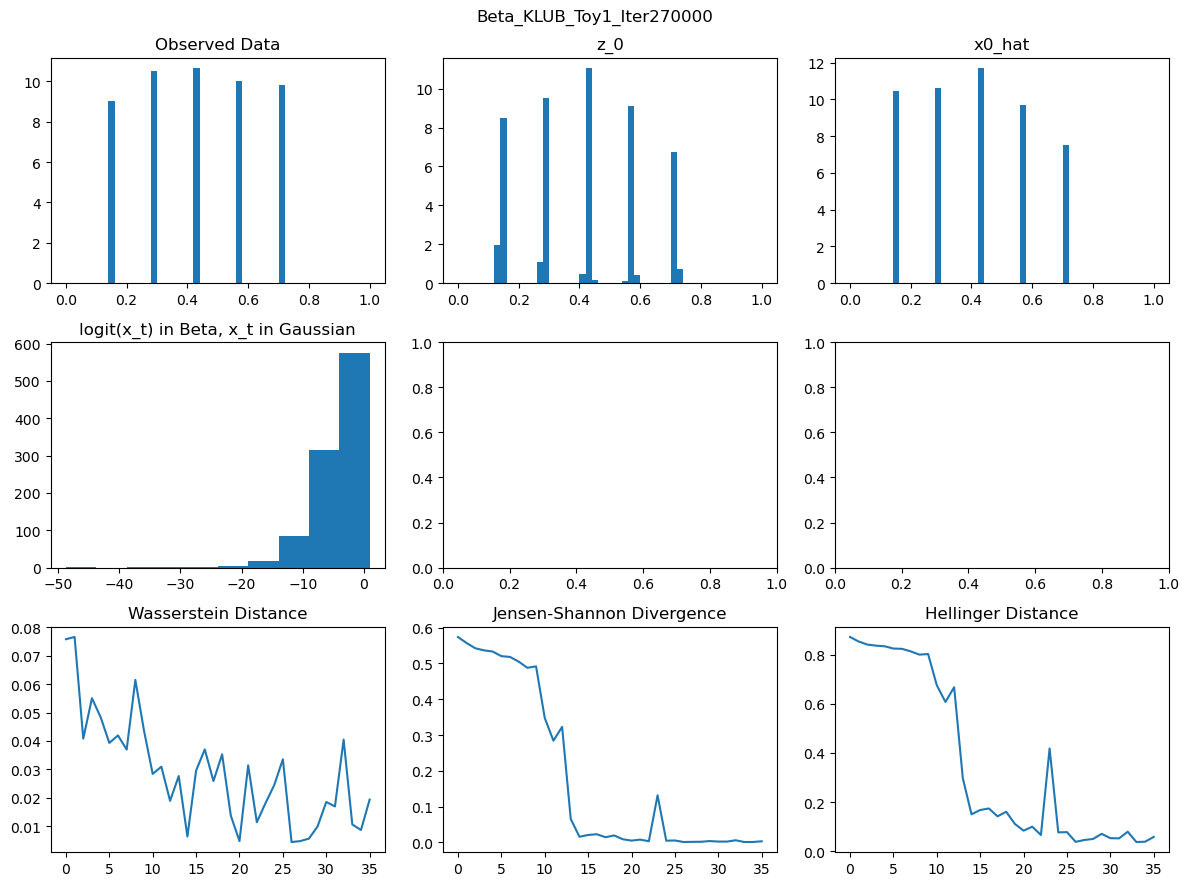

280000 tensor(0.1073, grad_fn=<MeanBackward0>)
280000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065
 0.0352988  0.01372386 0.00473645 0.03141224 0.01138221 0.01811088
 0.02443885 0.03354384 0.00440861 0.00473245 0.00560843 0.00991743
 0.01851851 0.01694372 0.04046638 0.01058327 0.00864791 0.01937367
 0.02128047]
280000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065
 0.01944626 0.00874669 0.00501089 0.00779572 0.00328969 0.13149794
 0.00472503 0.00539058 0.00105124 0.00156254 0.00176749 0.00374392
 0.00232108 0.00227073 0.0059205  0.0010873  0.00118629 0.00310376
 0.00192916]
280000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.83363808 0.82451119
 0.82321

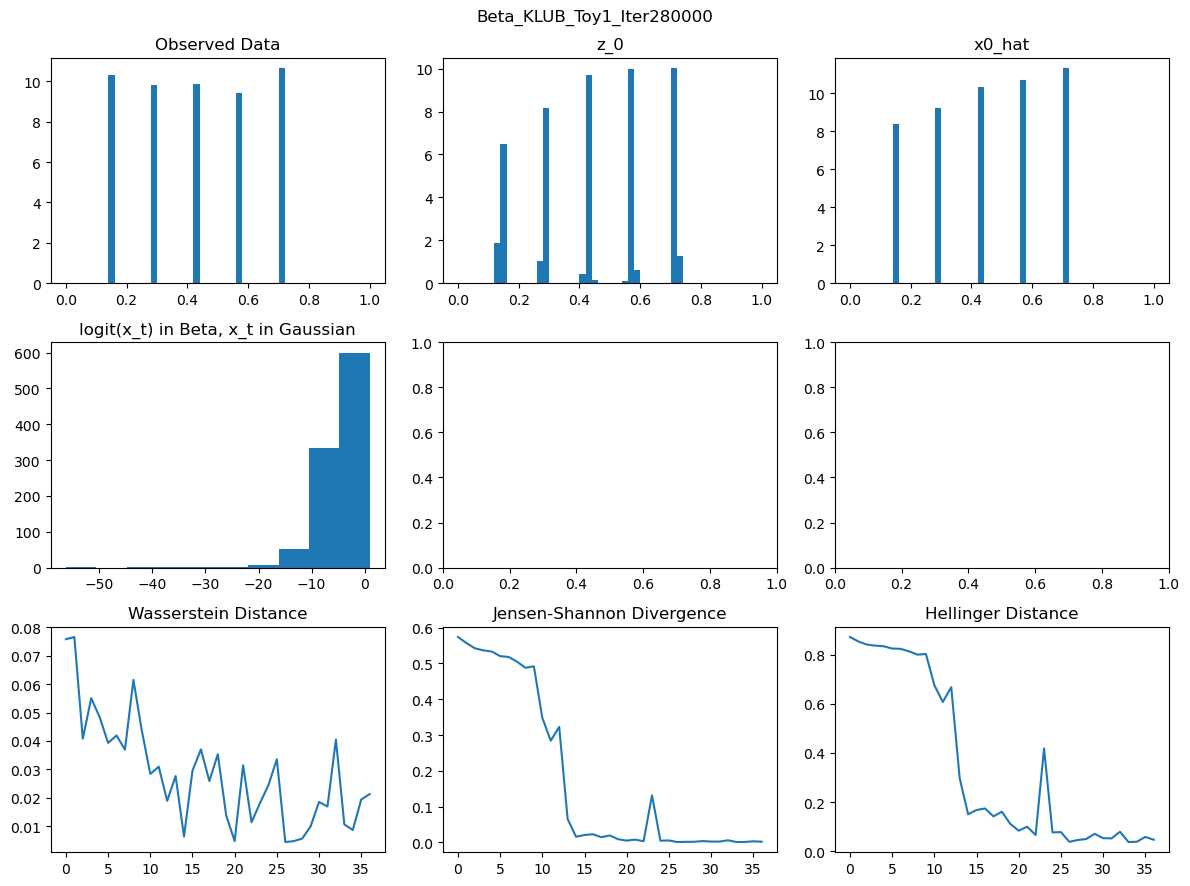

290000 tensor(0.0944, grad_fn=<MeanBackward0>)
290000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065
 0.0352988  0.01372386 0.00473645 0.03141224 0.01138221 0.01811088
 0.02443885 0.03354384 0.00440861 0.00473245 0.00560843 0.00991743
 0.01851851 0.01694372 0.04046638 0.01058327 0.00864791 0.01937367
 0.02128047 0.01600078]
290000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065
 0.01944626 0.00874669 0.00501089 0.00779572 0.00328969 0.13149794
 0.00472503 0.00539058 0.00105124 0.00156254 0.00176749 0.00374392
 0.00232108 0.00227073 0.0059205  0.0010873  0.00118629 0.00310376
 0.00192916 0.00173474]
290000 Hellinger [0.87150437 0.85306834 0.84065208 0.83626583 0.833638

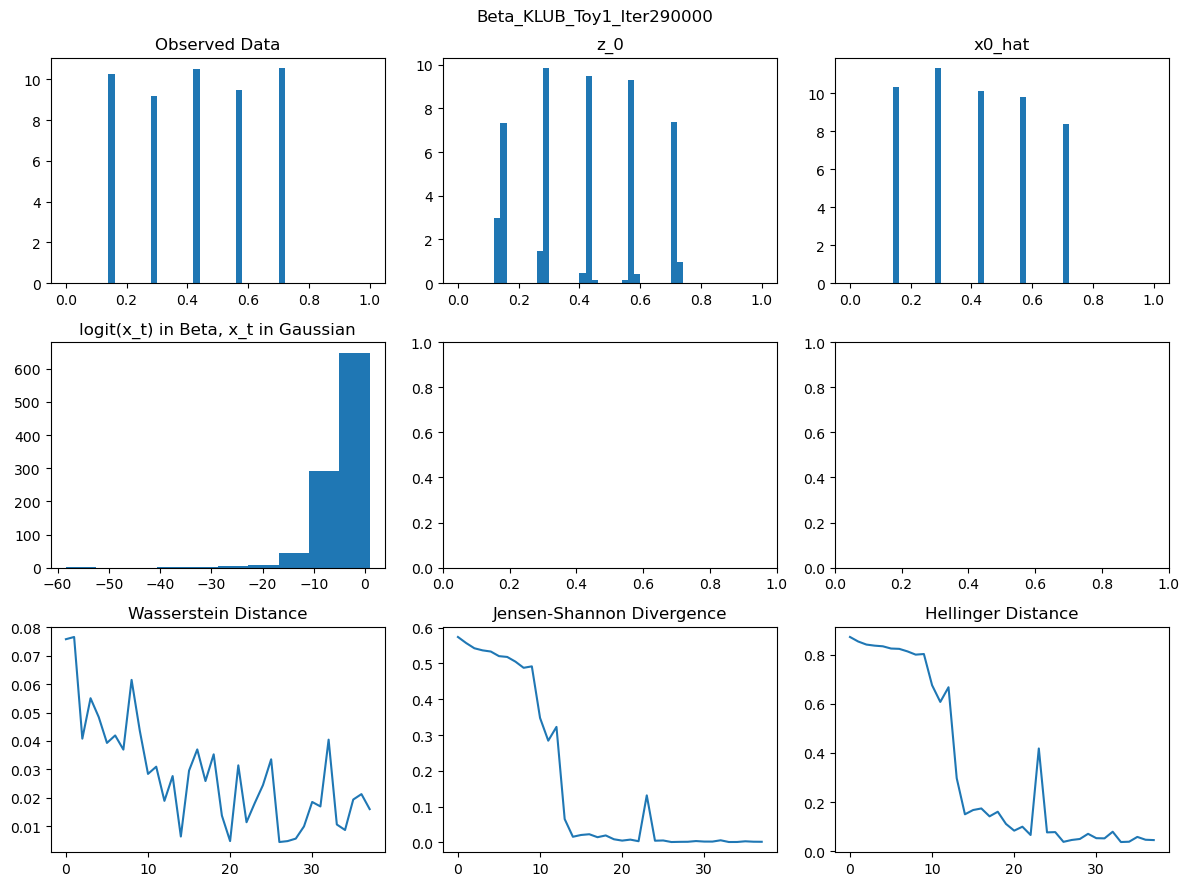

300000 tensor(0.1093, grad_fn=<MeanBackward0>)
300000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065
 0.0352988  0.01372386 0.00473645 0.03141224 0.01138221 0.01811088
 0.02443885 0.03354384 0.00440861 0.00473245 0.00560843 0.00991743
 0.01851851 0.01694372 0.04046638 0.01058327 0.00864791 0.01937367
 0.02128047 0.01600078 0.00820539]
300000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065
 0.01944626 0.00874669 0.00501089 0.00779572 0.00328969 0.13149794
 0.00472503 0.00539058 0.00105124 0.00156254 0.00176749 0.00374392
 0.00232108 0.00227073 0.0059205  0.0010873  0.00118629 0.00310376
 0.00192916 0.00173474 0.00058821]
300000 Hellinger [0.87150437 0.85306834 0.840652

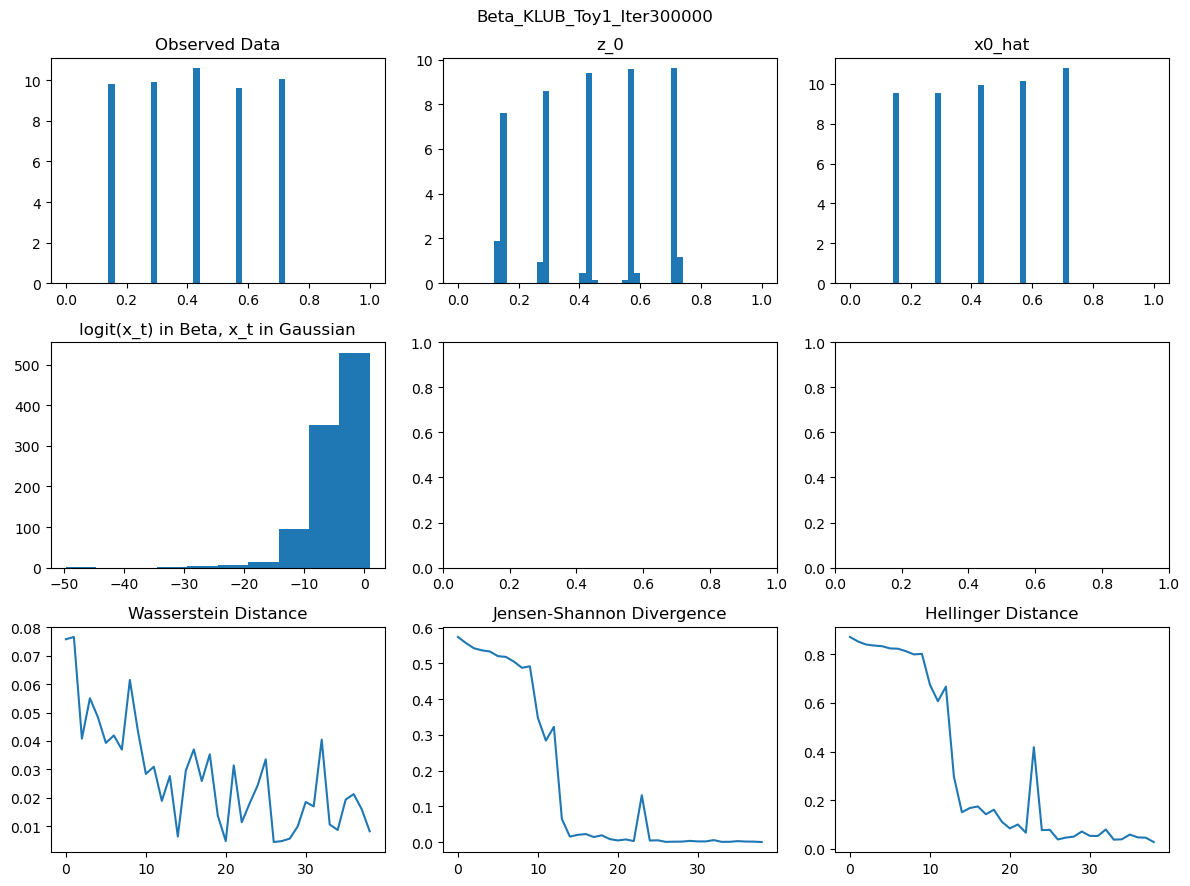

310000 tensor(0.1175, grad_fn=<MeanBackward0>)
310000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065
 0.0352988  0.01372386 0.00473645 0.03141224 0.01138221 0.01811088
 0.02443885 0.03354384 0.00440861 0.00473245 0.00560843 0.00991743
 0.01851851 0.01694372 0.04046638 0.01058327 0.00864791 0.01937367
 0.02128047 0.01600078 0.00820539 0.02193695]
310000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065
 0.01944626 0.00874669 0.00501089 0.00779572 0.00328969 0.13149794
 0.00472503 0.00539058 0.00105124 0.00156254 0.00176749 0.00374392
 0.00232108 0.00227073 0.0059205  0.0010873  0.00118629 0.00310376
 0.00192916 0.00173474 0.00058821 0.00204964]
310000 Hellinger [0.871504

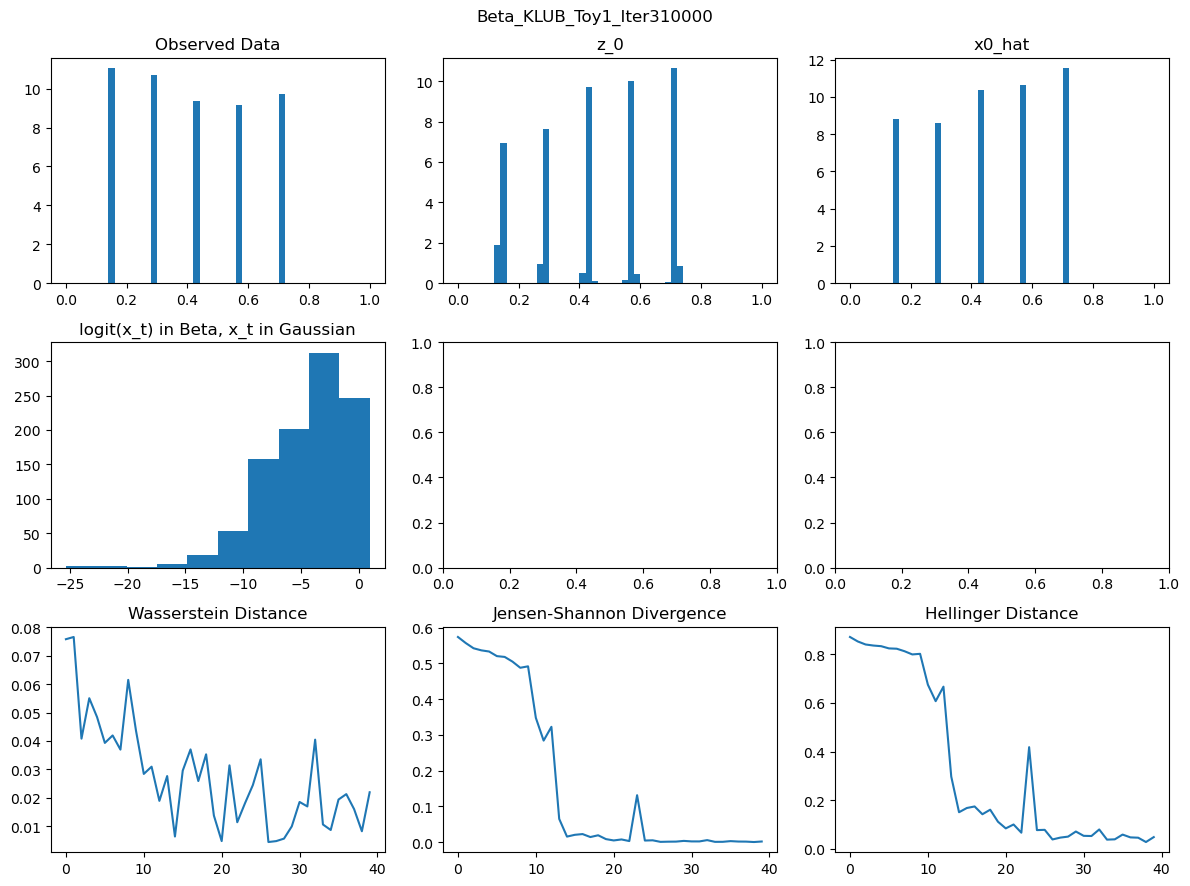

320000 tensor(0.1048, grad_fn=<MeanBackward0>)
320000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065
 0.0352988  0.01372386 0.00473645 0.03141224 0.01138221 0.01811088
 0.02443885 0.03354384 0.00440861 0.00473245 0.00560843 0.00991743
 0.01851851 0.01694372 0.04046638 0.01058327 0.00864791 0.01937367
 0.02128047 0.01600078 0.00820539 0.02193695 0.01855952]
320000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065
 0.01944626 0.00874669 0.00501089 0.00779572 0.00328969 0.13149794
 0.00472503 0.00539058 0.00105124 0.00156254 0.00176749 0.00374392
 0.00232108 0.00227073 0.0059205  0.0010873  0.00118629 0.00310376
 0.00192916 0.00173474 0.00058821 0.00204964 0.0022459 ]
3200

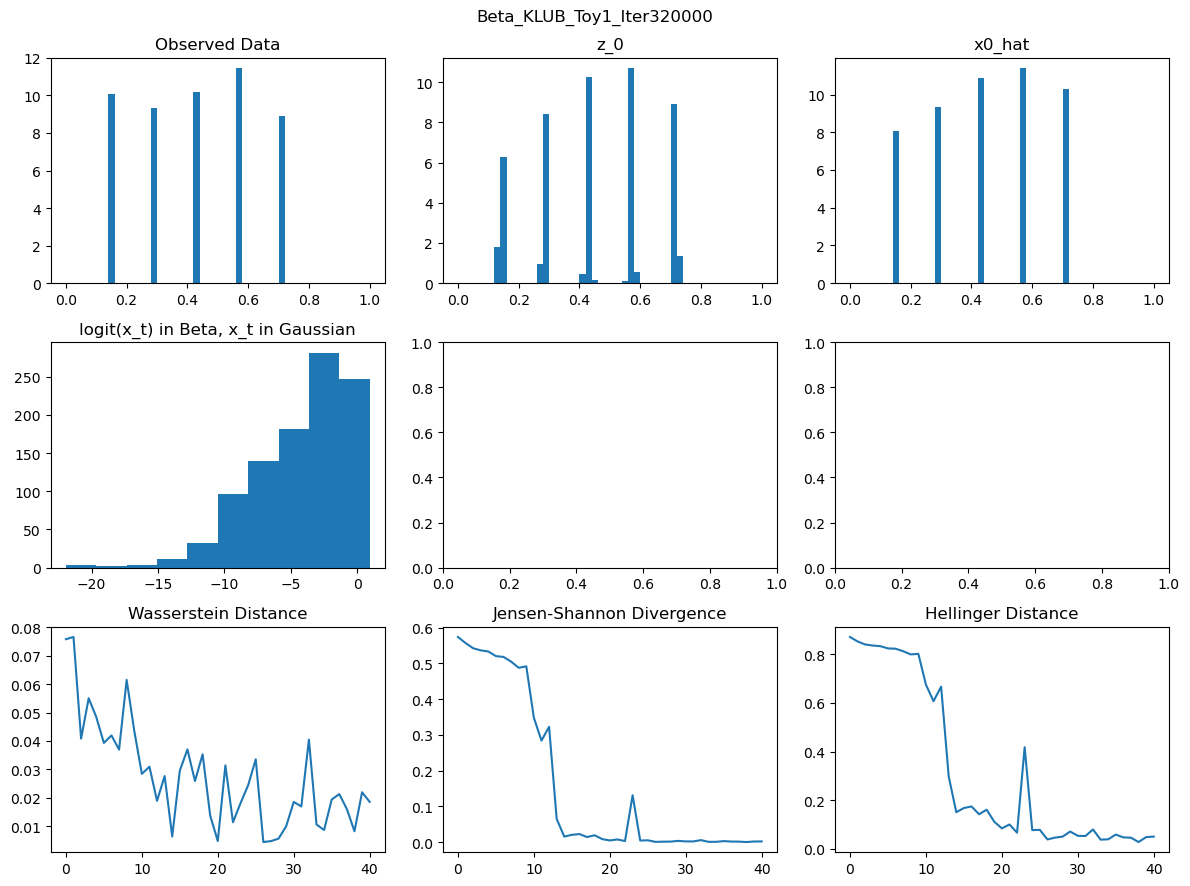

330000 tensor(0.0999, grad_fn=<MeanBackward0>)
330000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065
 0.0352988  0.01372386 0.00473645 0.03141224 0.01138221 0.01811088
 0.02443885 0.03354384 0.00440861 0.00473245 0.00560843 0.00991743
 0.01851851 0.01694372 0.04046638 0.01058327 0.00864791 0.01937367
 0.02128047 0.01600078 0.00820539 0.02193695 0.01855952 0.00914747]
330000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065
 0.01944626 0.00874669 0.00501089 0.00779572 0.00328969 0.13149794
 0.00472503 0.00539058 0.00105124 0.00156254 0.00176749 0.00374392
 0.00232108 0.00227073 0.0059205  0.0010873  0.00118629 0.00310376
 0.00192916 0.00173474 0.00058821 0.00204964 0.002

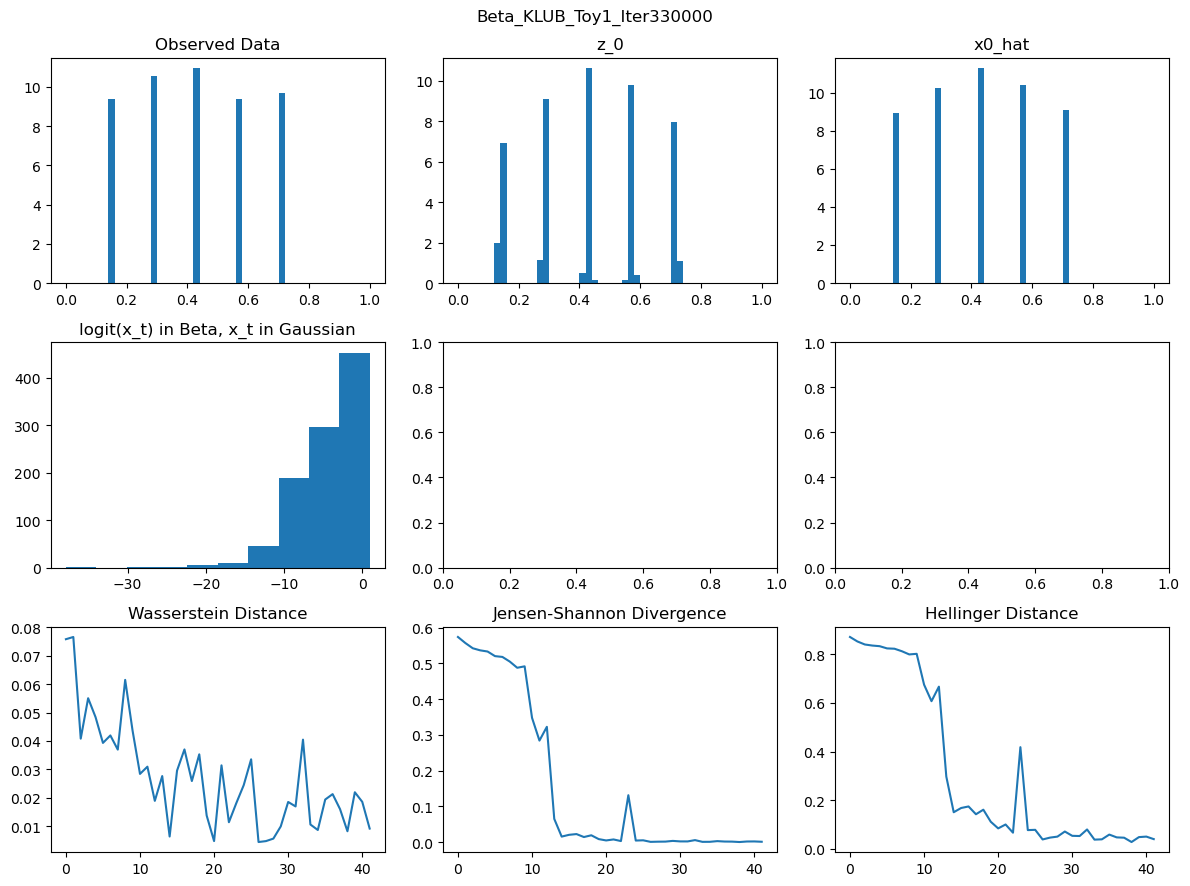

340000 tensor(0.0997, grad_fn=<MeanBackward0>)
340000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065
 0.0352988  0.01372386 0.00473645 0.03141224 0.01138221 0.01811088
 0.02443885 0.03354384 0.00440861 0.00473245 0.00560843 0.00991743
 0.01851851 0.01694372 0.04046638 0.01058327 0.00864791 0.01937367
 0.02128047 0.01600078 0.00820539 0.02193695 0.01855952 0.00914747
 0.01272715]
340000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065
 0.01944626 0.00874669 0.00501089 0.00779572 0.00328969 0.13149794
 0.00472503 0.00539058 0.00105124 0.00156254 0.00176749 0.00374392
 0.00232108 0.00227073 0.0059205  0.0010873  0.00118629 0.00310376
 0.00192916 0.00173474 0.00058821 0.00

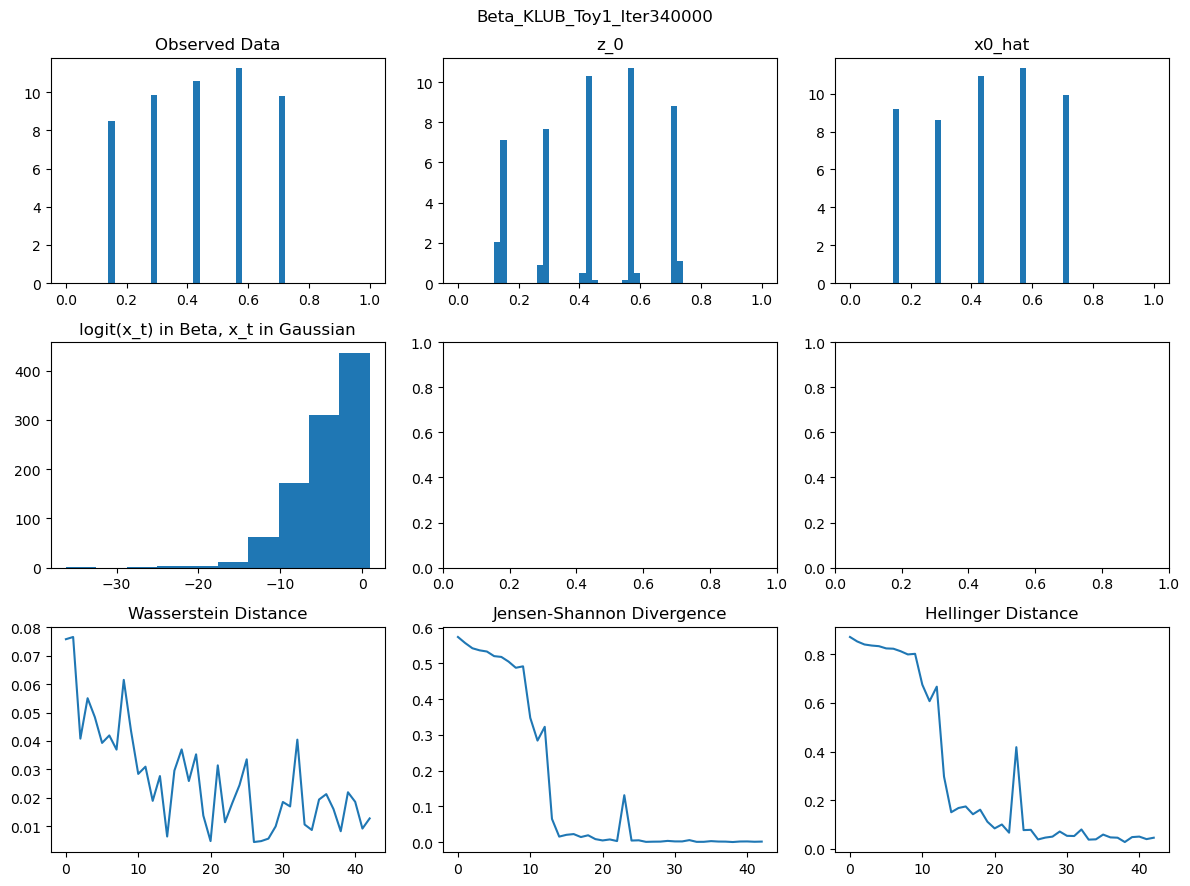

350000 tensor(0.1109, grad_fn=<MeanBackward0>)
350000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065
 0.0352988  0.01372386 0.00473645 0.03141224 0.01138221 0.01811088
 0.02443885 0.03354384 0.00440861 0.00473245 0.00560843 0.00991743
 0.01851851 0.01694372 0.04046638 0.01058327 0.00864791 0.01937367
 0.02128047 0.01600078 0.00820539 0.02193695 0.01855952 0.00914747
 0.01272715 0.01481382]
350000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065
 0.01944626 0.00874669 0.00501089 0.00779572 0.00328969 0.13149794
 0.00472503 0.00539058 0.00105124 0.00156254 0.00176749 0.00374392
 0.00232108 0.00227073 0.0059205  0.0010873  0.00118629 0.00310376
 0.00192916 0.00173474 0.00

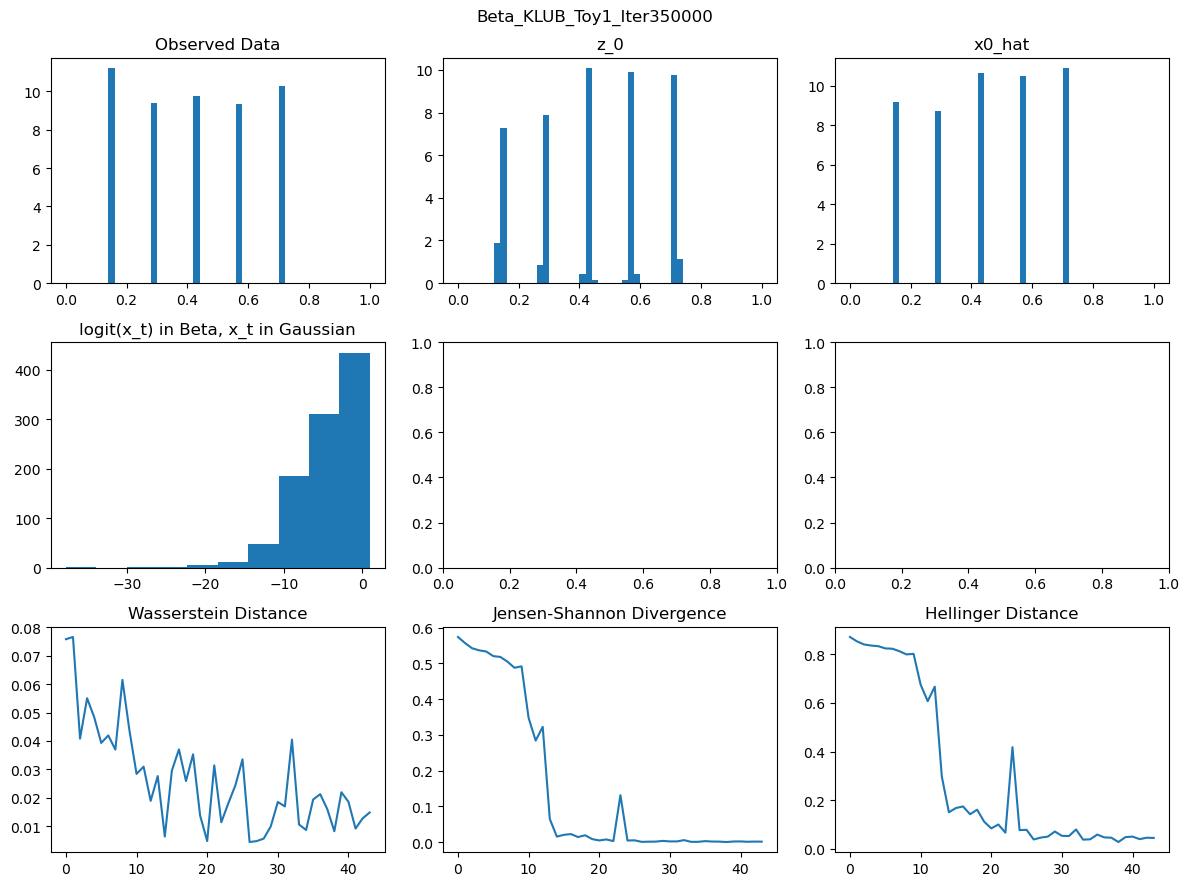

360000 tensor(0.0990, grad_fn=<MeanBackward0>)
360000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065
 0.0352988  0.01372386 0.00473645 0.03141224 0.01138221 0.01811088
 0.02443885 0.03354384 0.00440861 0.00473245 0.00560843 0.00991743
 0.01851851 0.01694372 0.04046638 0.01058327 0.00864791 0.01937367
 0.02128047 0.01600078 0.00820539 0.02193695 0.01855952 0.00914747
 0.01272715 0.01481382 0.0328057 ]
360000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065
 0.01944626 0.00874669 0.00501089 0.00779572 0.00328969 0.13149794
 0.00472503 0.00539058 0.00105124 0.00156254 0.00176749 0.00374392
 0.00232108 0.00227073 0.0059205  0.0010873  0.00118629 0.00310376
 0.00192916 0.00

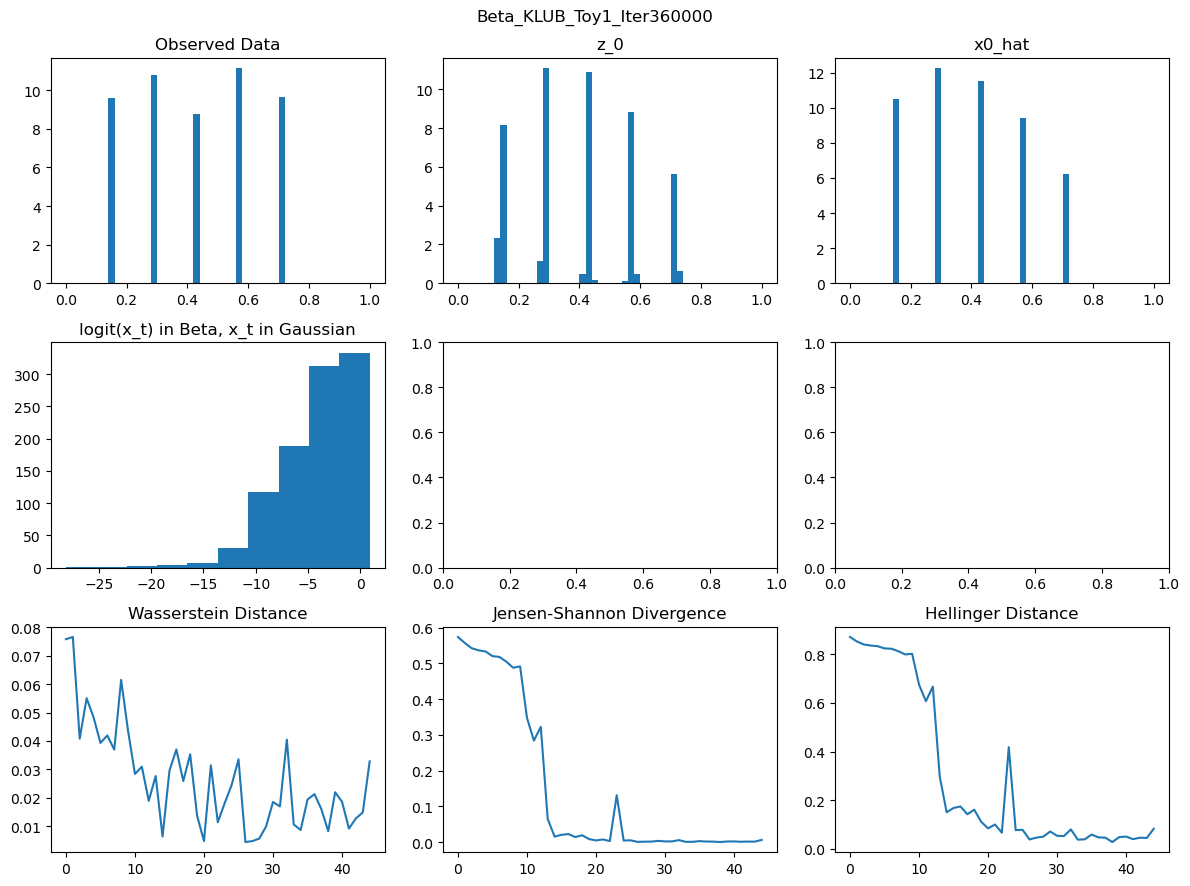

370000 tensor(0.1174, grad_fn=<MeanBackward0>)
370000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065
 0.0352988  0.01372386 0.00473645 0.03141224 0.01138221 0.01811088
 0.02443885 0.03354384 0.00440861 0.00473245 0.00560843 0.00991743
 0.01851851 0.01694372 0.04046638 0.01058327 0.00864791 0.01937367
 0.02128047 0.01600078 0.00820539 0.02193695 0.01855952 0.00914747
 0.01272715 0.01481382 0.0328057  0.01573633]
370000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065
 0.01944626 0.00874669 0.00501089 0.00779572 0.00328969 0.13149794
 0.00472503 0.00539058 0.00105124 0.00156254 0.00176749 0.00374392
 0.00232108 0.00227073 0.0059205  0.0010873  0.00118629 0.00310376
 0.00

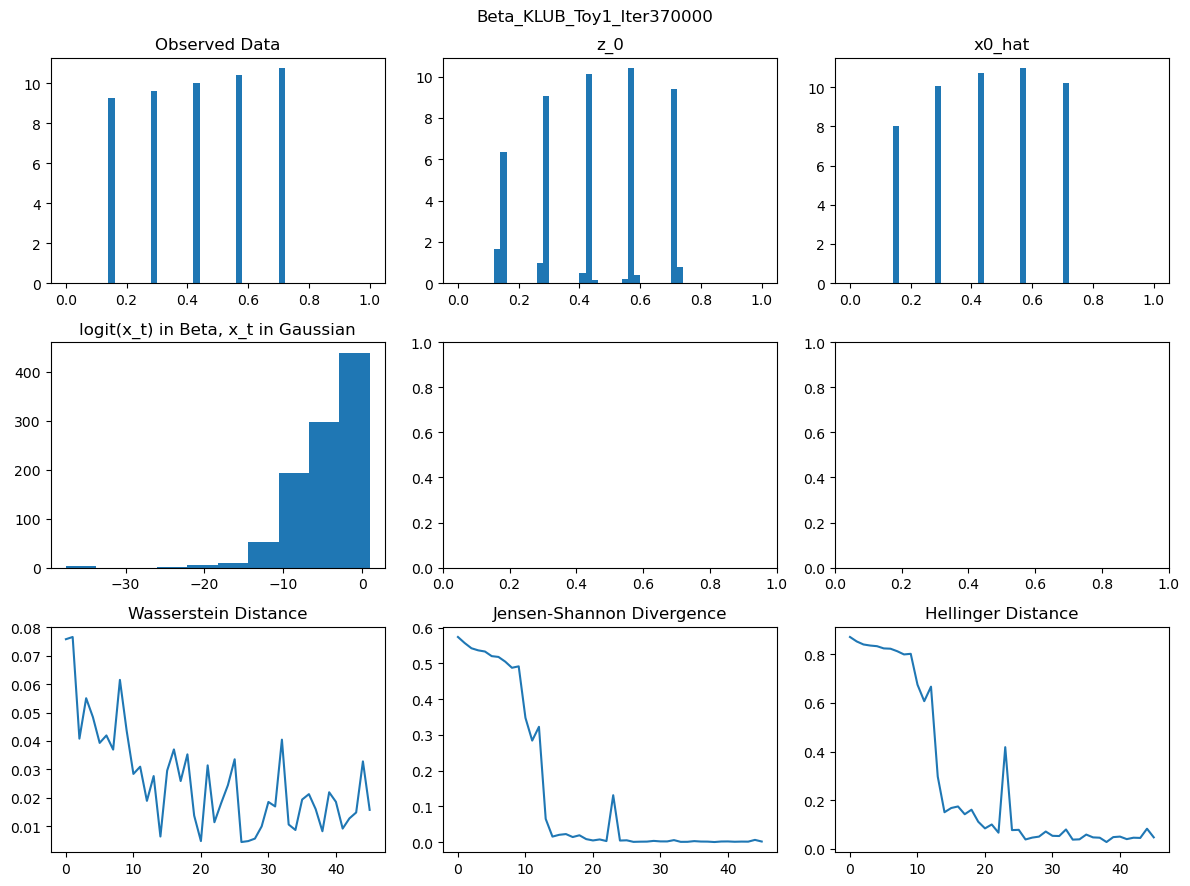

380000 tensor(0.1001, grad_fn=<MeanBackward0>)
380000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065
 0.0352988  0.01372386 0.00473645 0.03141224 0.01138221 0.01811088
 0.02443885 0.03354384 0.00440861 0.00473245 0.00560843 0.00991743
 0.01851851 0.01694372 0.04046638 0.01058327 0.00864791 0.01937367
 0.02128047 0.01600078 0.00820539 0.02193695 0.01855952 0.00914747
 0.01272715 0.01481382 0.0328057  0.01573633 0.01111963]
380000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065
 0.01944626 0.00874669 0.00501089 0.00779572 0.00328969 0.13149794
 0.00472503 0.00539058 0.00105124 0.00156254 0.00176749 0.00374392
 0.00232108 0.00227073 0.0059205  0.0010873  0.00118629 0.003

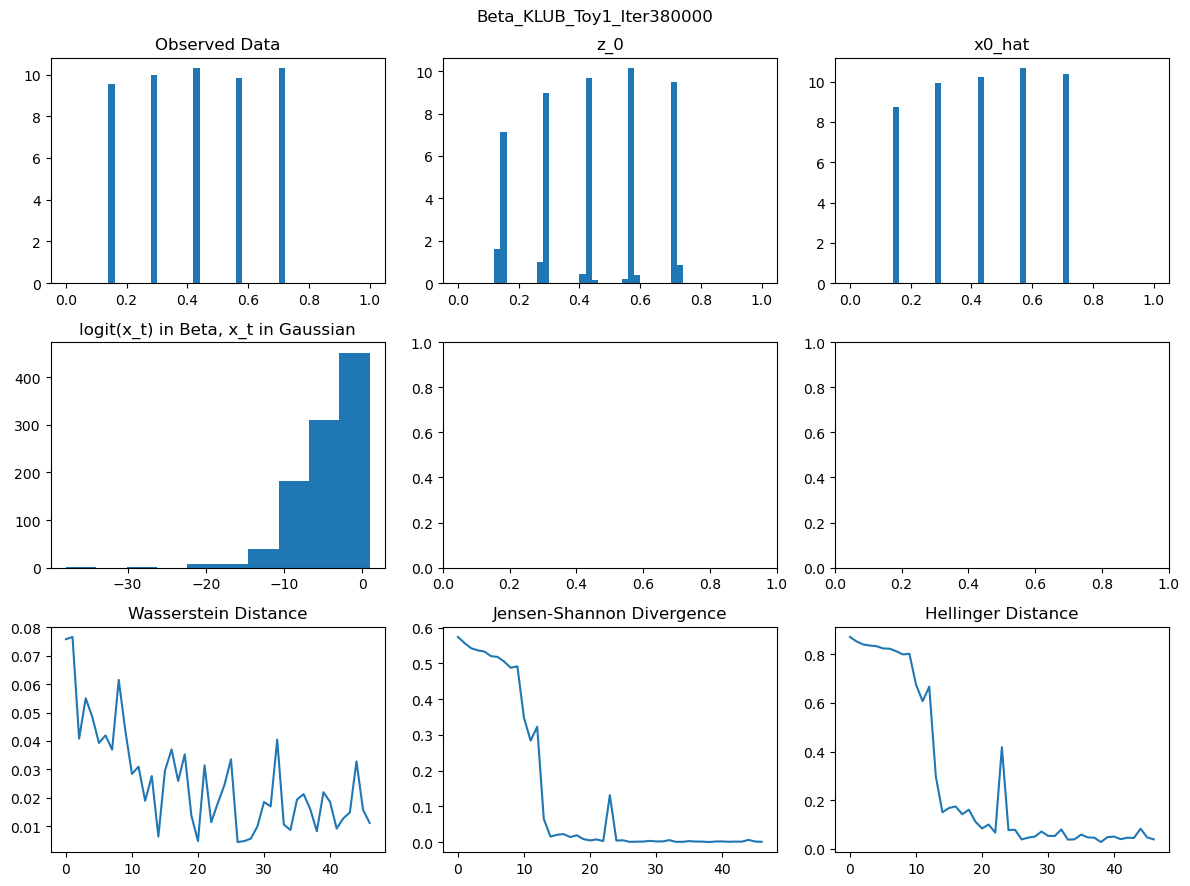

390000 tensor(0.1000, grad_fn=<MeanBackward0>)
390000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065
 0.0352988  0.01372386 0.00473645 0.03141224 0.01138221 0.01811088
 0.02443885 0.03354384 0.00440861 0.00473245 0.00560843 0.00991743
 0.01851851 0.01694372 0.04046638 0.01058327 0.00864791 0.01937367
 0.02128047 0.01600078 0.00820539 0.02193695 0.01855952 0.00914747
 0.01272715 0.01481382 0.0328057  0.01573633 0.01111963 0.0144239 ]
390000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065
 0.01944626 0.00874669 0.00501089 0.00779572 0.00328969 0.13149794
 0.00472503 0.00539058 0.00105124 0.00156254 0.00176749 0.00374392
 0.00232108 0.00227073 0.0059205  0.0010873  0.001

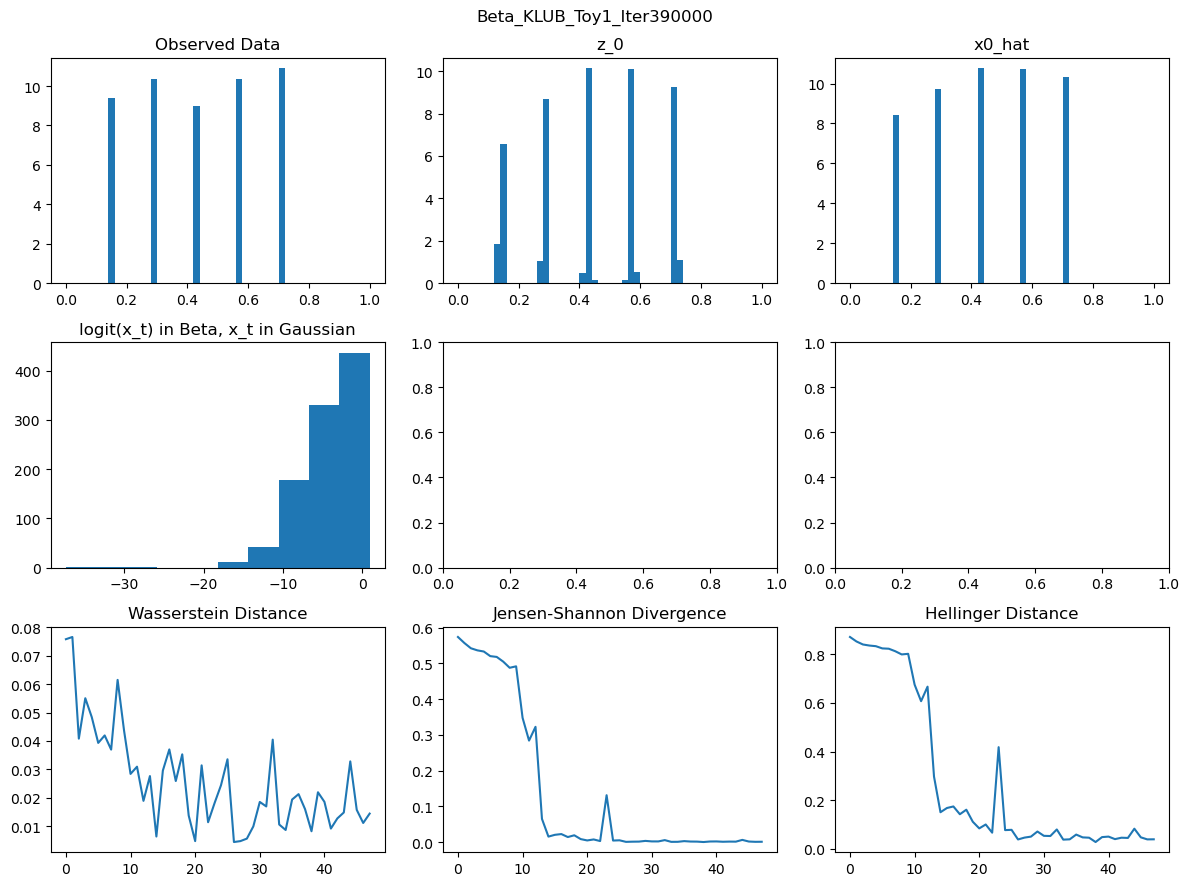

400000 tensor(0.1148, grad_fn=<MeanBackward0>)
400000 Wasserstein1 [0.07584224 0.0766233  0.04082273 0.05505493 0.04840197 0.03931636
 0.04194656 0.03695915 0.06151482 0.04360259 0.02839603 0.03094629
 0.01890634 0.02764593 0.00634956 0.02956361 0.0370223  0.02589065
 0.0352988  0.01372386 0.00473645 0.03141224 0.01138221 0.01811088
 0.02443885 0.03354384 0.00440861 0.00473245 0.00560843 0.00991743
 0.01851851 0.01694372 0.04046638 0.01058327 0.00864791 0.01937367
 0.02128047 0.01600078 0.00820539 0.02193695 0.01855952 0.00914747
 0.01272715 0.01481382 0.0328057  0.01573633 0.01111963 0.0144239
 0.00944373]
400000 JSD [0.57403056 0.55709281 0.54251595 0.53666749 0.53338518 0.52050362
 0.51825427 0.5051738  0.48793322 0.4919524  0.3479297  0.28427989
 0.32278814 0.06525641 0.01575595 0.02074841 0.02282074 0.01453065
 0.01944626 0.00874669 0.00501089 0.00779572 0.00328969 0.13149794
 0.00472503 0.00539058 0.00105124 0.00156254 0.00176749 0.00374392
 0.00232108 0.00227073 0.0059205  0.001

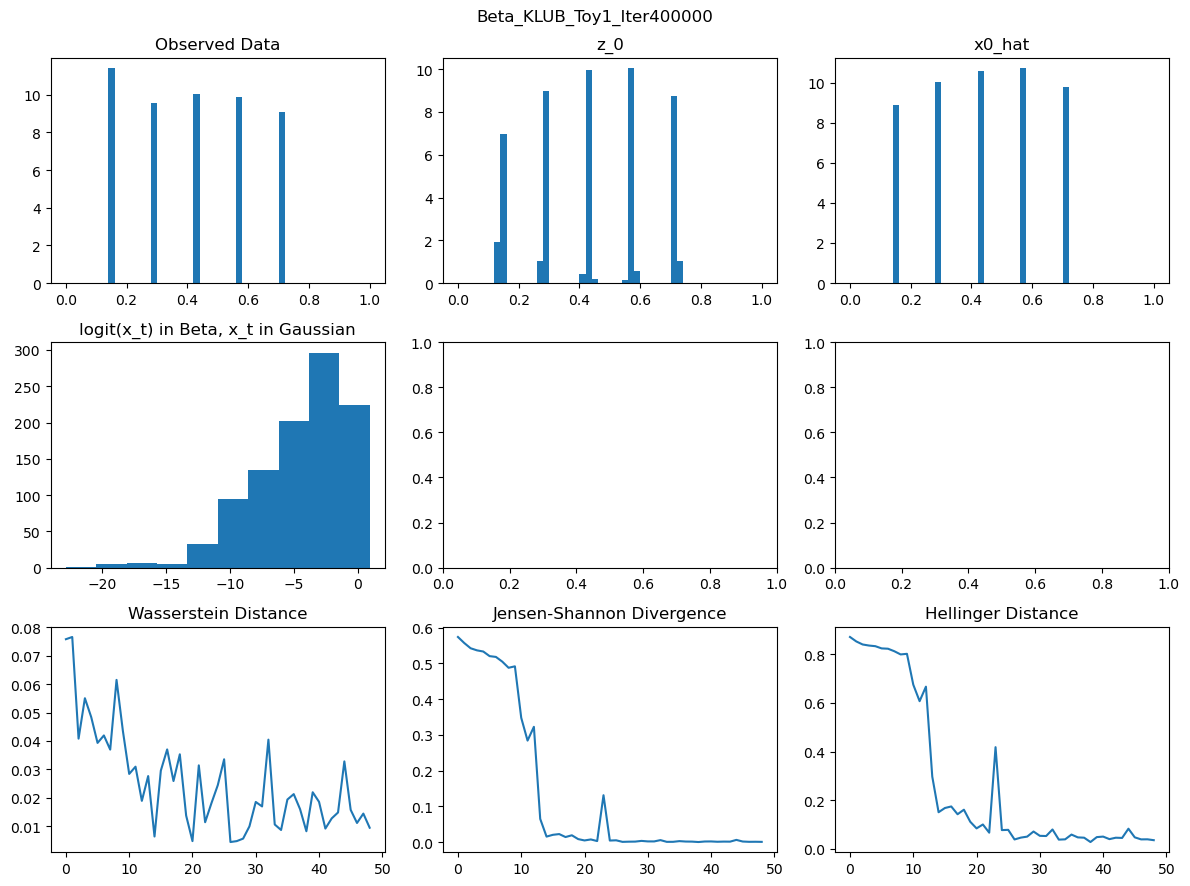

In [7]:
iter=1
epoch=0
Wasserstein1= np.array([])
Hellinger = np.array([])
JSD = np.array([])
Iter = np.array([])
while (iter<=400000):
    iter=iter+1  
   
    """
    Draw a minibatch of data from the true data distribution
    """  
    x0,D = draw_minibatch(BatchSize,data_choice)
    
    """
    Define time position for each data point
    """  
    flag=True
    #while flag:
    if 1:
        #uniform random positions Unif(1e-5,1)
        #current time t
        position = 1-torch.rand(BatchSize,1)*(1-1e-5)
        #previous time s
        Pi = 0.95
        position_previous = position*Pi
        
        #position_previous = (position-1/T).clamp(min=0)
        #alpha_t
        if Beta_Linear_Schedule==False:
            logit_alpha = sigmoid_start+(sigmoid_end-sigmoid_start)*(position**sigmoid_power)
            logit_alpha_previous = sigmoid_start+(sigmoid_end-sigmoid_start)*(position_previous**sigmoid_power)
        else:
            logit_alpha = (-0.5*beta_d*position**2-beta_min*position).to(torch.float64).exp().logit().to(torch.float32)
            logit_alpha_previous = (-0.5*beta_d*position_previous**2-beta_min*position_previous).to(torch.float64).exp().logit().to(torch.float32)
            
        alpha = torch.sigmoid(logit_alpha)
        alpha_previous = torch.sigmoid(logit_alpha_previous)
        #delta = alpha_previous - alpha
        
        delta  = (logit_alpha_previous.to(torch.float64).sigmoid()-logit_alpha.to(torch.float64).sigmoid()).to(torch.float32)
        
        #eta_delta  = (eta*logit_alpha_previous.to(torch.float64).sigmoid()-eta*logit_alpha.to(torch.float64).sigmoid()).to(torch.float32)
        
        #embedding_pos = alpha
        embedding_pos = position
    
        pe = get_positional_embedding(embed_size, embedding_pos)
        
        #pe = get_positional_embedding(embed_size, alpha)
        #pe = get_positional_embedding(embed_size, -logit_alpha/8)
              


    if diffusion_option == "Beta":
        #sample x~Beta(a,b) using x= u/(u+v), u~Gamma(a,1), v~Gamma(v,1)
        #logit(x) = log(x/(1-x)) = log(u)-log(v), where u~Gamma(a,1), v~Gamma(v,1)
        #log_u = log_gamma(eta*(alpha[t]*x0+epsilon).clamp(MIN,1-EPS))
        #log_v = log_gamma(eta*(1-alpha[t]*x0).clamp(MIN,1-EPS))
            
        x0_Scale_Shift = x0*Scale + Shift
        log_u = log_gamma(eta*alpha*x0_Scale_Shift)
        log_v = log_gamma(eta-eta*alpha*x0_Scale_Shift)
        logit_x_t = log_u - log_v

        if torch.isnan(logit_x_t).any():
            print(iter)
            print("NaN in logit_x_t detected in the tensor. Stopping code.")
            sys.exit()
        
        logit_x0_hat = model(logit_x_t, pe)  
        
        x0_hat = torch.sigmoid(logit_x0_hat) *Scale+Shift

        if torch.isnan(x0_hat).any():
            print(iter)
            print("NaN in x0_hat detected in the tensor. Stopping code.")
            sys.exit()
        

        alpha_p = eta*delta*x0_Scale_Shift 
        #alpha_p = eta_delta*x0_Scale_Shift 
        beta_p = eta-eta*alpha_previous*x0_Scale_Shift

        alpha_q = eta*delta*x0_hat
        #alpha_q = eta_delta*x0_hat
        beta_q  = eta-eta*alpha_previous*x0_hat 

        _alpha_p = eta*alpha*x0_Scale_Shift
        _beta_p  = eta-eta*alpha*x0_Scale_Shift
        _alpha_q = eta*alpha*x0_hat
        _beta_q  = eta-eta*alpha*x0_hat 
            
            
        #KL is nonnegative in theory, so clamp then at 0
        #The KL between beta distributions can be written as three different KLs between gamma distributions.
        
        KLUB_conditional = (KL_gamma(alpha_q,alpha_p).clamp(0)\
                            + KL_gamma(beta_q,beta_p).clamp(0)\
                            - KL_gamma(alpha_q+beta_q,alpha_p+beta_p).clamp(0)).clamp(0)
        KLUB_marginal = (KL_gamma(_alpha_q,_alpha_p).clamp(0)\
                            + KL_gamma(_beta_q,_beta_p).clamp(0)\
                            - KL_gamma(_alpha_q+_beta_q,_alpha_p+_beta_p).clamp(0)).clamp(0)
        
        ELBO_conditional = (KL_gamma(alpha_p,alpha_q).clamp(0)\
                                + KL_gamma(beta_p,beta_q).clamp(0)\
                                - KL_gamma(alpha_p+beta_p,alpha_q+beta_q).clamp(0)).clamp(0)
            
        ELBO_marginal = (KL_gamma(_alpha_p,_alpha_q).clamp(0)\
                                + KL_gamma(_beta_p,_beta_q).clamp(0)\
                                - KL_gamma(_alpha_p+_beta_p,_alpha_q+_beta_q).clamp(0)).clamp(0)
        
        if loss_option == "KLUB":
            loss = (.5*KLUB_conditional+.5*KLUB_marginal).mean()
        elif loss_option == "KLUB_conditional":
            loss = KLUB_conditional.mean()
        elif loss_option == "KLUB_marginal":            
            loss = KLUB_marginal.mean()
        elif loss_option == "ELBO": 
            loss = (0.5*ELBO_conditional+0.5*ELBO_marginal).mean()
        elif loss_option == "ELBO_conditional":  
            loss = ELBO_conditional.mean()
        elif loss_option == "ELBO_marginal":  
            loss = ELBO_marginal.mean()
        else:
            print("Invalid loss option")
    elif diffusion_option == "Gauss":
        noise_in = torch.randn_like(x0)
        #x_t = torch.sqrt(alpha)*x0+torch.sqrt(1.0-alpha)*noise_in
        x_t = torch.sqrt(alpha)*x0+torch.exp(0.5*torch.log1p(-alpha))*noise_in
        if Predict_x0:
            x0_hat = model(x_t, pe)
            L2 = (x0-x0_hat)**2
        else:
            noise_pred = model(x_t,pe) 
            #x0_hat = ((x_t - torch.sqrt(1-alpha)*noise_pred)/torch.sqrt(alpha))
            x0_hat = ((x_t - torch.exp(0.5*torch.log1p(-alpha))*noise_pred)/torch.sqrt(alpha))
            L2 = (noise_in-noise_pred)**2
        if Predict_x0:
            #KLUB_conditional = torch.exp(torch.log(delta)-torch.log(torch.tensor(2))-torch.log1p(-alpha_previous)-torch.log1p(-alpha))*L2
            #KLUB_marginal = torch.exp(torch.log(alpha)-torch.log1p(-alpha))*L2
            KLUB_conditional = 0.5*(logit_alpha_previous.exp()- logit_alpha.exp())*L2
            KLUB_marginal = logit_alpha.exp()*L2
        else:
            #KLUB_conditional = torch.exp(torch.log(delta)-torch.log(torch.tensor(2))-torch.log1p(-alpha_previous)-torch.log(alpha))*L2
            #KLUB_marginal = L2
            KLUB_conditional = 0.5* (logit_alpha_previous-logit_alpha).expm1()*L2 # torch.exp(torch.log(delta)-torch.log(torch.tensor(2))-torch.log1p(-alpha_previous)-torch.log(alpha))*L2
            KLUB_marginal = L2
        
        if loss_option == "KLUB":
            KLUB = 0.5*KLUB_conditional+0.5*KLUB_marginal
            loss = KLUB.mean()        
        elif loss_option == "KLUB_conditional":
            loss = KLUB_conditional.mean()
        elif loss_option == "KLUB_marginal" or loss_option == "Weighted_ELBO":   
            loss = KLUB_marginal.mean()
        else:
            print("Invalid loss option")
    else:
        print("Invalid diffusion option")
        
    if torch.isnan(loss).any():
        print("NaN in loss detected in the tensor. Stopping code.")
        sys.exit()
    
    optimizer.zero_grad()
    loss.backward()
    #gradient norm regularization
    #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()
    
    
    if (iter%1000==0 and iter<10000) or iter%10000==0:
    #if iter>2:
        print(iter,loss)
        if False:
            #Optional learning rate decay
            scheduler.step()
            print("Learning rate:", optimizer.param_groups[0]['lr'])
    
        datashape = x0.shape
        delta = torch.cat([torch.tensor([[1.0]]),alpha[0:-1]])-alpha       
        
        num_steps = T
        
#         if diffusion_option == "Beta":
#             x0_hat,z_1 = beta_reverse_sampler(model,datashape,num_steps,alpha,diffusion_option,Scale,Shift,embed_size)
#         else:
#             x0_hat,z_1 = gauss_reverse_sampler(model,datashape,num_steps,alpha,embed_size)
    
        
        #generate 100k data points to calcuate evaluation metrics
        Size = 100000
        datashape = (Size,1)
        #z_1, x0_hat = reverse_diffusion(model,datashape,TT,pe,alpha,delta,diffusion_option,alpha_min)
        if diffusion_option == "Beta":
            x0_hat,z_1 = beta_reverse_sampler(model,datashape,num_steps,alpha,diffusion_option,Scale,Shift,embed_size)
        else:
            x0_hat,z_1 = gauss_reverse_sampler(model,datashape,num_steps,alpha,embed_size)

        
        if data_choice=="Type1":
            x0_ =D.repeat_interleave(int(datashape[0]/len(D)))
            W1 = torch.mean(torch.abs(x0_ - torch.sort(x0_hat.squeeze()).values)).numpy()
        else:
            x0_,_ = draw_minibatch(Size,data_choice)
            W1 = torch.mean(torch.abs(torch.sort(x0_.squeeze()).values - torch.sort(x0_hat.squeeze()).values)).numpy()    
        Wasserstein1 = np.append( Wasserstein1,W1)
        print(iter,"Wasserstein1",Wasserstein1)
        Iter = np.append( Iter,iter)
        
        #Generated data
        data = x0_hat.squeeze().numpy()
        bins = np.linspace(0, 1, num=101)
        # Create histogram
        hist, bins = np.histogram(data, bins)
        # Compute empirical frequency
        q = hist / len(data)

        # True data
        data = x0_.squeeze().numpy()
        # Create histogram
        hist, bins = np.histogram(data, bins)
        # Compute empirical frequency
        p = hist / len(data)

        JSD1 = np.sum(p[p>0]*np.log(p[p>0]/(p[p>0]/2.0+q[p>0]/2.0))) 
        JSD2 = np.sum(q[q>0]*np.log(q[q>0]/(p[q>0]/2.0+q[q>0]/2.0)))
        JSDnew = JSD1/2 + JSD2/2

        JSD  = np.append(JSD,JSDnew)
        Hellinger = np.append(Hellinger, np.sqrt(np.sum((np.sqrt(p)-np.sqrt(q))**2))/np.sqrt(2))
        
        print(iter,"JSD", JSD)
        print(iter,"Hellinger",Hellinger)
        
        epoch = epoch+1
        if SaveCheckPoint:
            checkpoint_path = f'results/BetaDiff_model_checkpoint_{data_choice}_{diffusion_option}_{loss_option}_{epoch}.pth'
            torch.save(model.state_dict(), checkpoint_path)
        
            results_path = f'results/BetaDiff_results_{data_choice}_{diffusion_option}_{loss_option}_{epoch}.pth'
            torch.save((Iter,Wasserstein1, JSD,Hellinger),  results_path)
        
        # Set the bin edges for the histograms

        bin_edges = torch.linspace(0, 1.0, 51)
        # Create subplots
        fig, axs = plt.subplots(3, 3, figsize=(12, 9))

        # Plot the observed data
        axs[0, 0].hist(x0.numpy(), bin_edges, density=True)
        axs[0, 0].set_title("Observed Data")

        # Plot the reversed latent variable z_1 with 10 steps, random positions
        axs[0, 1].hist(z_1.numpy(), bin_edges, density=True)
        axs[0, 1].set_title("z_0")

        # Plot the reversed data estimation with 10 steps, random positions
        axs[0, 2].hist(x0_hat.numpy(), bin_edges, density=True)
        axs[0, 2].set_title("x0_hat")

        # Plot logit(x_t) in Beta and x_t in Gaussian
        if diffusion_option == "Beta":
            axs[1, 0].hist(logit_x_t.numpy())
        else:
            axs[1, 0].hist(x_t.numpy())
        axs[1, 0].set_title("logit(x_t) in Beta, x_t in Gaussian")


        # Plot the Wasserstein distance
        axs[2, 0].plot(Wasserstein1)
        axs[2, 0].set_title("Wasserstein Distance")

        # Plot the JSD (Jensen-Shannon Divergence)
        axs[2, 1].plot(JSD)
        axs[2, 1].set_title("Jensen-Shannon Divergence")

        # Plot the Hellinger distance
        axs[2, 2].plot(Hellinger)
        axs[2, 2].set_title("Hellinger Distance")
        plt.suptitle(f'{diffusion_option}_{loss_option}_{data_choice}_Iter{iter}')
        # Adjust spacing between subplots
        plt.tight_layout()
        # Show the plot
        plt.show()